# Analysis of the effect of ethnicity on food purchase in London's Tesco supermarkets

The goal of our study is to observe the impact of the ethnicity of Tesco's customers in London on the kind of alimentary products they purchase.
To achieve this, we will use the Tesco Grocery 1.0 dataset that reports the food items purchased in London's Tesco supermarket and extend it with the LSOA atlas, a dataset containing sensus data, which gives us information on the representation of different ethnic groups accross the city of London. 

We will first study the correlations between ethnicity and the type of products purchased at different levels of granularity. We will look if ethnic diversity is linked to diversity in grocery purchase, if the various represented ethnic groups correlate differently to the diversity in grocery purchase and how the represented ethnic groups correlate with the different food product categories reported in the Tesco dataset.

After that, we will move forward and try to assess if the distribution of the different ethnic groups and their diversity has a causal effect on the variation of food purchases, when taking into account other socio-economic features reported in the LSOA atlas that could act as confounders. We will first carry a simple linear regression analysis, followed by a propensity score matching analysis.

Before getting started it is worth to pay attention to one of the Tesco dataset limitations. The data reported being only issued from grocery purchases done at Tesco, it is not truly representative of the overall food habits of the London's inhabitants. To address this issue, the authors created a representativity feature from the number of different customers and the total population of the area to get a sense of how much Tesco groceries purchases could explain the overall dietary habits. After trying to filter our dataset to get a high level of representativeness, we noticed that we rejected too many areas to allow further analysis. We hence decided to focus our study on shopping habits rather than eating habits by keeping all LSOA regardless of their representativity level.

Here are the key questions that we would like to answer with this project:
- Does ethnic diversity have an effect on food purchase diversity at area level?
- And if yes, what is its nature? 
- To which extent is ethnic diversity responsible for food purchase diversity?  
- To which extent are ethnicities responsible for the changes in some product categories purchases? Can we attribute particular food purchase habits to specific ethnic groups?

---

The results presented in this Notebook, as well as some fancy visualizations are available in our Data Story at the following link:
https://evanbeal.github.io/EnchilADAs/

---

## Table of contents

* 1. Data cleaning
    * 1.1. Loading of the data
    * 1.2. Cleaning and filtering of the data
        * 1.2.1. Tesco dataset
        * 1.2.2. LSOA atlas
        * 1.2.3. Merging the different datasets
* 2. Data wrangling
* 3. Exploration of the dataset
* 4. Correlation analysis
    * 4.1. Correlation between ethnic diversity and product categories diversity
    * 4.2. Correlation between the different proportions of ethnic groups and product categories diversity
    * 4.3. Correlation between the different proportions of ethnic groups and different proportions of product categories
* 5. Causality analysis
    * 5.1. Naive initial analysis using Linear Regression
    * 5.2. Propensity Score matching
        * 5.2.1. Towards propensity score matching with a continuous treatment feature
        * 5.2.2. Generalized Propensity Score (GPS) matching
        * 5.2.3. Deriving a metric to measure the signficance of the treatment effect
        * 5.2.4. Modularity
    * 5.3. Assessing our approach
        * 5.3.1. Impact of the number of features used to compute the propensity score
        * 5.3.2. Link between causality and correlation results
    * 5.4. Anaylsis of the effect of each ethnicity on the product categories entropies   
    * 5.5. Anaylsis of the effect of each ethnicity on each food/drink category 
    * 5.6. Interpretations of the results
* 6. Conclusion
* 7. Annex (visualizations for Data Story)

---

#### Set the environment

In [1]:
### Classic imports 

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib

import os


### Imports for statistical analysis

import scipy
from scipy.stats import spearmanr

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split


### Imports for specific visualizations

import geopandas as gpd

import plotly
import plotly.express as px
import plotly.graph_objects as go


### Import associated to propensity score matching

from causal_curve import GPS


### Other imports

import re


---

## 1. Data cleaning

### 1.1. Loading of the data

The data used for this study are issued from three different datasets:

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

- **Tesco Grocery 1.0 dataset** (Aiello, L.M., Quercia, D., Schifanella, R. et al. Tesco Grocery 1.0, a large-scale dataset of grocery purchases in London. Sci Data 7, 57 (2020). https://doi.org/10.1038/s41597-020-0397-7) (https://figshare.com/collections/Tesco_Grocery_1_0/4769354/2): Record of food items purchased by fidelity card owners at Tesco stores in Greater london over the year 2015, aggregated at Lower Super Output Area (LSOA) level. For each area, this dataset reports properties (weight, nutrient composition) of the typical food item bought. All purchased items used to generate this dataset were also clustered into 17 non-overlapping product categories (e.g. red mead, dairy, fruit & vegetables, bottled water, beer, etc.). The probability distribution of items belonging to the 17 different product categories  is also reported for each area, as well as the entropy of this distribution, that serves as a measure of food products diversity.

In [3]:
tesco_df = pd.read_csv(TESCO_PATH)
tesco_df.sample(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
554,E01000566,443.959182,40.0,188.0,335.0,500.0,1500.0,635.422128,4.269729,134.817569,...,18358,1520.0,787.0,733.0,324.0,950.0,246.0,39.844737,0.21,7276.0
3842,E01003932,379.223601,40.0,170.0,300.0,485.0,1000.0,393.495146,1.997408,110.522509,...,33428,1570.0,799.0,771.0,261.0,1197.0,112.0,34.040127,0.12,12837.0
1384,E01001406,405.135238,40.0,180.0,324.0,500.0,1100.0,394.624324,2.400020,113.960944,...,12347,1635.0,765.0,870.0,354.0,1064.0,217.0,38.114985,0.20,8011.0
2241,E01002293,313.508971,30.0,125.0,242.0,400.0,1000.0,337.978182,4.633524,94.475884,...,5959,1919.0,957.0,962.0,369.0,1315.0,235.0,36.954664,0.69,2790.0
3694,E01003780,435.051495,40.0,177.0,330.0,500.0,1200.0,665.182348,6.197542,127.672793,...,6547,1574.0,784.0,790.0,316.0,964.0,294.0,42.031131,0.30,5245.0


- **LSOA atlas** (https://data.london.gov.uk/dataset/lsoa-atlas): an official summary of demographic data for the city of London for the year 2011, aggregated at LSOA level. This contains many socio-economic features of the the London's LSOA such as ethnic groups repartitions that we will use for our study.

In [4]:
lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
lsoa_df.sample(5)

,Lower Super Output Area,Names,Mid-year Population Estimates;All Ages;2001,Mid-year Population Estimates;All Ages;2002,Mid-year Population Estimates;All Ages;2003,Mid-year Population Estimates;All Ages;2004,Mid-year Population Estimates;All Ages;2005,Mid-year Population Estimates;All Ages;2006,Mid-year Population Estimates;All Ages;2007,Mid-year Population Estimates;All Ages;2008,...,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total,Road Casualties;2013;Fatal,Road Casualties;2013;Serious,Road Casualties;2013;Slight,Road Casualties;2013;2013 Total,Road Casualties;2014;Fatal,Road Casualties;2014;Serious,Road Casualties;2014;Slight,Road Casualties;2014;2014 Total
1037,E01003261,Lewisham 021D,1505.0,1505.0,1479.0,1443.0,1455.0,1397.0,1479.0,1497.0,...,2.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,3.0,3.0
2825,E01001013,Croydon 020B,1566.0,1611.0,1615.0,1670.0,1693.0,1726.0,1760.0,1804.0,...,10.0,10.0,0.0,0.0,5.0,5.0,0.0,0.0,13.0,13.0
533,E01002061,Haringey 036A,1447.0,1502.0,1474.0,1462.0,1482.0,1516.0,1540.0,1624.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4349,E01003639,Redbridge 013A,1493.0,1530.0,1558.0,1618.0,1650.0,1644.0,1669.0,1666.0,...,3.0,4.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
2679,E01000841,Bromley 030H,1528.0,1519.0,1533.0,1541.0,1547.0,1572.0,1596.0,1593.0,...,4.0,7.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0


- **Geographical information dataset of the LSOA** (https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london): Range of key GIS boundary files for ESRI and Map Info covering Greater London. This dataset will be used for visualization purposes as it will allow to display some of the results on the London map with relevant values assigned to each geographical region representing the LSOA. 

In [5]:
map_df = gpd.read_file(GEO_LSOA_PATH)
map_df.sample(5)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
529,E01000539,Brent 004C,E02000096,Brent 004,E09000005,Brent,E12000007,London,1541,1541,0,54.2,548,2.8,"POLYGON ((518345.665 188365.331, 518354.048 18..."
1312,E01001332,Ealing 008E,E02000245,Ealing 008,E09000009,Ealing,E12000007,London,1503,1503,0,109.5,579,2.6,"POLYGON ((512218.000 182787.000, 512436.318 18..."
2139,E01002189,Harrow 016B,E02000448,Harrow 016,E09000015,Harrow,E12000007,London,1661,1661,0,37.4,714,2.3,"POLYGON ((511937.446 189781.793, 511976.435 18..."
535,E01000546,Brent 028B,E02000120,Brent 028,E09000005,Brent,E12000007,London,1645,1645,0,173.2,756,2.2,"POLYGON ((524537.562 184216.302, 524558.526 18..."
1926,E01001974,Haringey 001C,E02000397,Haringey 001,E09000014,Haringey,E12000007,London,2198,2198,0,124.8,959,2.3,"POLYGON ((530176.510 191647.062, 530332.422 19..."


---

### 1.2. Cleaning and filtering of the data

#### 1.2.1. Tesco dataset

First we need to filter the tesco dataset to keep only what is interesting to our study:

Since we are mainly interested in the food purchase diversity, we decide to keep only the columns reporting the proportions of the different item categories as well as their normalized entropy. The nutritive values is indeed of no use for our analysis.
We also decide to keep the last columns of the dataset that report different demographic informations about the LSOAs.

In [6]:
def filter_and_clean_tesco(tesco_df):
    """
    filter the tesco dataset by removing columns not useful for our study
    """
    
    filtered_df = tesco_df.loc[:, 'area_id']
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'f_beer':'f_wine'] ], axis=1)
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'h_items_norm'] ], axis=1)
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'representativeness_norm':] ], axis=1)

    return filtered_df

print("Size before filtering:", tesco_df.shape)
filt_tesco_df = filter_and_clean_tesco(tesco_df)
print("After filtering:", filt_tesco_df.shape)

Size before filtering: (4833, 202)
After filtering: (4833, 32)


#### 1.2.2. LSOA atlas

We then also need to filter and clean the LSOA dataset:

We decide to drop some columns that report information already present in the tesco dataset:
- Population estimates
- Population ages
- Population density

We drop the road casualities data as well as they are irrelevant to our question of interest.

This dataset is composed mainly of socio-economic data from 2011, some of the columns however have also values for other years in addition. We decide to keep only the data related to year 2011 to keep consistency.

Finally, many of the values reported in the dataset are reported both as an absolute number of people/household and as a percentage of the total population/number of household in a certain area. When this is the case, we decide to keep only the percentage values and to transform them into ratio comprised between 0 and 1 to keep consistency with the proportions reported in the tesco dataset that features this format.

In [7]:
def filter_and_clean_losa(lsoa_df):
    """
    Filter the LSOA dataset by removing columns not useful for our study
    """
    
    filtered_df = lsoa_df.copy()
    
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    filtered_df.drop(lsoa_df.tail(2).index,inplace=True)
    
    ##### REPLACE UNKNOWN VALUES #####
    filtered_df.replace('-', np.NaN, inplace=True)
    filtered_df.replace('.', np.NaN, inplace=True)

    ##### DROP ALL IRRELEVANT COLUMNS #####
    # Mid-year Population Estimates (already in tesco data)
    # Census Population (already in tesco data)
    # Population Density (already in tesco data)
    # Road casualties (irrelevant)
    to_remove = ['Mid-year Population Estimates',
                 'Census Population',
                 'Population Density',
                 'BAME',
                 'Economically active: Total',
                 'Economically inactive: Total',
                 'Road Casualties']
    to_drop = []
    for col in filtered_df.columns:
        for sub in to_remove:
            if(sub in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS NOT RELATED TO 2011 #####
    to_drop = []
    for col in filtered_df.columns:
        nums = re.findall('[0-9]+', col)
        for num in nums:
            if(len(num) == 4 and num != '2011'):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS THAT ARE ABSOLUTE VALUE IF THERE IS PROPORTIONS FOR SAME DATA #####
    to_drop = []
    begin_with = ['Household Composition',
                  'Ethnic Group',
                  'Country of Birth',
                  'Household Language',
                  'Religion',
                  'Tenure',
                  'Dwelling type',
                  'Qualifications',
                  'Health',
                  'Car or van availability',
                  'Adults in Employment',
                  'Lone Parents']
    for col in filtered_df.columns:
        for sub in begin_with:
            if(col.startswith(sub) and '%' not in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### TRANSFORM ALL PERCENTAGES VALUES IN RATIO BETWEEN 0 AND 1 #####
    for col in filtered_df.columns:
        if('%' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("%", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True) 
            
        if('Rate' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("Rate", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True)
    
    # remove spaces in column names
    filtered_df.columns = filtered_df.columns.str.replace(' ', '_')
    
    return filtered_df

print("Size before filtering:", lsoa_df.shape)
filt_lsoa_df = filter_and_clean_losa(lsoa_df)
print("After filtering:", filt_lsoa_df.shape)

Size before filtering: (4837, 277)
After filtering: (4835, 67)


#### 1.2.3. Merging the different datasets

After the cleaning, we can now merge our different dataset of interest in a single one that we will use through the rest of our study.

In [8]:
def merge_data(tesco_df, lsoa_df, map_df):
    '''
    merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(tesco_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower_Super_Output_Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df


full_df = merge_data(filt_tesco_df, filt_lsoa_df, map_df)
print('Shape after merging:', full_df.shape)
full_df.sample(5)

Shape after merging: (4833, 112)


,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
Ealing 005A,E01001341,Ealing 005A,E02000242,Ealing 005,E09000009,Ealing,E12000007,London,1712,1712,...,0.837,0.127,0.036,0.223,0.490,0.225,0.047,0.015,38666.0,30136.0
Richmond upon Thames 015C,E01003900,Richmond upon Thames 015C,E02000798,Richmond upon Thames 015,E09000027,Richmond upon Thames,E12000007,London,1562,1562,...,0.816,0.127,0.057,0.292,0.427,0.230,0.042,0.010,42060.0,32418.0
Ealing 014B,E01001259,Ealing 014B,E02000251,Ealing 014,E09000009,Ealing,E12000007,London,1457,1457,...,0.848,0.111,0.040,0.310,0.420,0.184,0.055,0.031,35655.0,27797.0
Tower Hamlets 002C,E01004199,Tower Hamlets 002C,E02000865,Tower Hamlets 002,E09000030,Tower Hamlets,E12000007,London,1637,1637,...,0.767,0.141,0.092,0.685,0.286,0.026,0.002,0.002,34235.0,25885.0
Hammersmith and Fulham 018C,E01001917,Hammersmith and Fulham 018C,E02000389,Hammersmith and Fulham 018,E09000013,Hammersmith and Fulham,E12000007,London,1462,1462,...,0.830,0.120,0.051,0.471,0.404,0.110,0.015,0.001,60859.0,46207.0


---

## 2. Data wrangling

To get a sense of the diversity of certain features, such as the ethnic group proportions for example. We compute a normalized entropy for those distributions in the same fashion as presented in the Tesco paper.

In [9]:
def compute_h_norm(df, f_col_list):
    
    f_df = df[f_col_list]
    n_col = len(f_col_list)
        
    h_df = pd.DataFrame()
    
    if np.any(f_df > 1):
        f_df = f_df.div(f_df.sum(axis=1), axis=0)
        
    # compute intermediates values inside the sum of eq (12)
    for col in f_df.columns:
        col_val = f_df[col] * np.log2(f_df[col])
        h_df.insert(len(h_df.columns), col, col_val, True)

    # compute the entropy as the sum of the intermediates values
    h = - h_df.sum(axis=1)
    h_df.insert(0, 'h', h, True)

    # remove all the intermediate values from the dataframe
    h_df = h_df.iloc[:, :1]

    # normalization
    h_df['h_norm'] = h_df['h'] / np.log2(n_col)
    
    return h_df['h_norm'].values

To add a bit of depth to the analysis, we decide to also compute 2 new entropies corresponding to food-only and drink-only items in addition to the product categories entropy already present in the tesco dataset.

In [10]:
food_col_list = ['f_dairy',
                 'f_eggs',
                 'f_fats_oils',
                 'f_fish',
                 'f_fruit_veg',
                 'f_grains',
                 'f_meat_red',
                 'f_poultry',
                 'f_readymade',
                 'f_sauces',
                 'f_sweets']

h_items_food_norm = compute_h_norm(full_df, food_col_list)

# insert new column
new_h_idx = full_df.columns.get_loc('h_items_norm') 
full_df.insert(new_h_idx, 'h_items_food_norm', h_items_food_norm.tolist(), True)

drink_col_list = ['f_beer',
                  'f_soft_drinks',
                  'f_spirits',
                  'f_tea_coffee',
                  'f_water',
                  'f_wine']

h_items_drink_norm = compute_h_norm(full_df, drink_col_list)

# insert two new column
new_h_idx = full_df.columns.get_loc('h_items_norm') 
full_df.insert(new_h_idx, 'h_items_drink_norm', h_items_drink_norm.tolist(), True)

We compute the entropy of the probability distribution of the different ethnic groups in each area to get a sense of the ethnic diversity.

In [11]:
ethnicities_col_list = ['Ethnic_Group;White_(ratio);2011',
                        'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                        'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                        'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                        'Ethnic_Group;Other_ethnic_group_(ratio);2011']

h_ethnicities_norm = compute_h_norm(full_df, ethnicities_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities_norm;2011', h_ethnicities_norm.tolist(), True)

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Finally, we add a few more entropy features in the dataset that capture the diversity of certain groups of related features.

In [12]:
household_compo_col_list = ['Household_Composition;ratio_Couple_household_with_dependent_children;2011',
                            'Household_Composition;ratio_Lone_parent_household;2011',
                            'Household_Composition;ratio_One_person_household;2011',
                            'Household_Composition;ratio_Other_multi_person_household;2011']

religion_col_list = ['Religion;Christian_(ratio);2011', 'Religion;Buddhist_(ratio);2011',
                     'Religion;Hindu_(ratio);2011', 'Religion;Jewish_(ratio);2011',
                     'Religion;Muslim_(ratio);2011', 'Religion;Sikh_(ratio);2011',
                     'Religion;Other_religion_(ratio);2011',
                     'Religion;No_religion_(ratio);2011',
                     'Religion;Religion_not_stated_(ratio);2011']

tenure_col_list = ['Tenure;Owned_outright_(ratio);2011',
                   'Tenure;Owned_with_a_mortgage_or_loan_(ratio);2011',
                   'Tenure;Social_rented_(ratio);2011',
                   'Tenure;Private_rented_(ratio);2011']

dwelling_col_list = ['Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011',
                     'Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Semi-detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Terraced_(including_end-terrace)_(ratio);2011',
                     'Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011']

eco_activity_col_list = ['Economic_Activity;Economically_active:_Employee;2011',
                         'Economic_Activity;Economically_active:_Self-employed;2011',
                         'Economic_Activity;Economically_active:_Unemployed;2011',
                         'Economic_Activity;Economically_active:_Full-time_student;2011']

qualif_col_list = ['Qualifications;ratio_No_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_1_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_2_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Apprenticeship;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_3_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_4_qualifications_and_above;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Other_qualifications;2011',
                   'Qualifications;ratio_Schoolchildren_and_full-time_students:_Age_18_and_over;2011']

health_activ_col_list = ['Health;Day-to-day_activities_limited_a_lot_(ratio);2011',
                         'Health;Day-to-day_activities_limited_a_little_(ratio);2011',
                         'Health;Day-to-day_activities_not_limited_(ratio);2011']

health_state_col_list = ['Health;Very_good_or_Good_health_(ratio);2011',
                         'Health;Fair_health_(ratio);2011',
                         'Health;Bad_or_Very_Bad_health_(ratio);2011']

car_avail_col_list = ['Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;1_car_or_van_in_household_(ratio);2011',
                      'Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011']

age_col_list = ['age_0_17', 'age_18_64', 'age_65+']


h_household_compo_norm = compute_h_norm(full_df, household_compo_col_list)
h_religion_norm = compute_h_norm(full_df, religion_col_list)
h_tenure_norm = compute_h_norm(full_df, tenure_col_list)
h_dwelling_norm = compute_h_norm(full_df, dwelling_col_list)
h_eco_activity_norm = compute_h_norm(full_df, eco_activity_col_list)
h_qualif_norm = compute_h_norm(full_df, qualif_col_list)
h_health_activ_norm = compute_h_norm(full_df, health_activ_col_list)
h_health_state_norm = compute_h_norm(full_df, health_state_col_list)
h_car_avail_norm = compute_h_norm(full_df, car_avail_col_list)
h_age_norm = compute_h_norm(full_df, age_col_list)


# insert the new columns
new_h_idx = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011') 
full_df.insert(new_h_idx, 'h_household_compo_norm', h_household_compo_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Tenure;Owned_outright_(ratio);2011')
full_df.insert(new_h_idx, 'h_religion_norm', h_religion_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011')
full_df.insert(new_h_idx, 'h_tenure_norm', h_tenure_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('House_Prices;Median_Price_(£);2011')
full_df.insert(new_h_idx, 'h_dwelling_norm', h_dwelling_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Qualifications;ratio_No_qualifications;2011')
full_df.insert(new_h_idx, 'h_eco_activity_norm', h_eco_activity_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Health;Day-to-day_activities_limited_a_lot_(ratio);2011')
full_df.insert(new_h_idx, 'h_qualif_norm', h_qualif_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Health;Very_good_or_Good_health_(ratio);2011')
full_df.insert(new_h_idx, 'h_health_activ_norm', h_health_activ_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011')
full_df.insert(new_h_idx, 'h_health_state_norm', h_health_state_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)')
full_df.insert(new_h_idx, 'h_car_avail_norm', h_car_avail_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('area_sq_km')
full_df.insert(new_h_idx, 'h_age_norm', h_age_norm.tolist(), True)


full_df.shape

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(4833, 125)

---

## 3. Exploration of the dataset

As a first step of our study, we take a look at the distribution of our two main features of interest: the ethnic and food product categories entropies, as well as some of the socio-economic features that, in our intuition, could act as confounder in our later analysis.

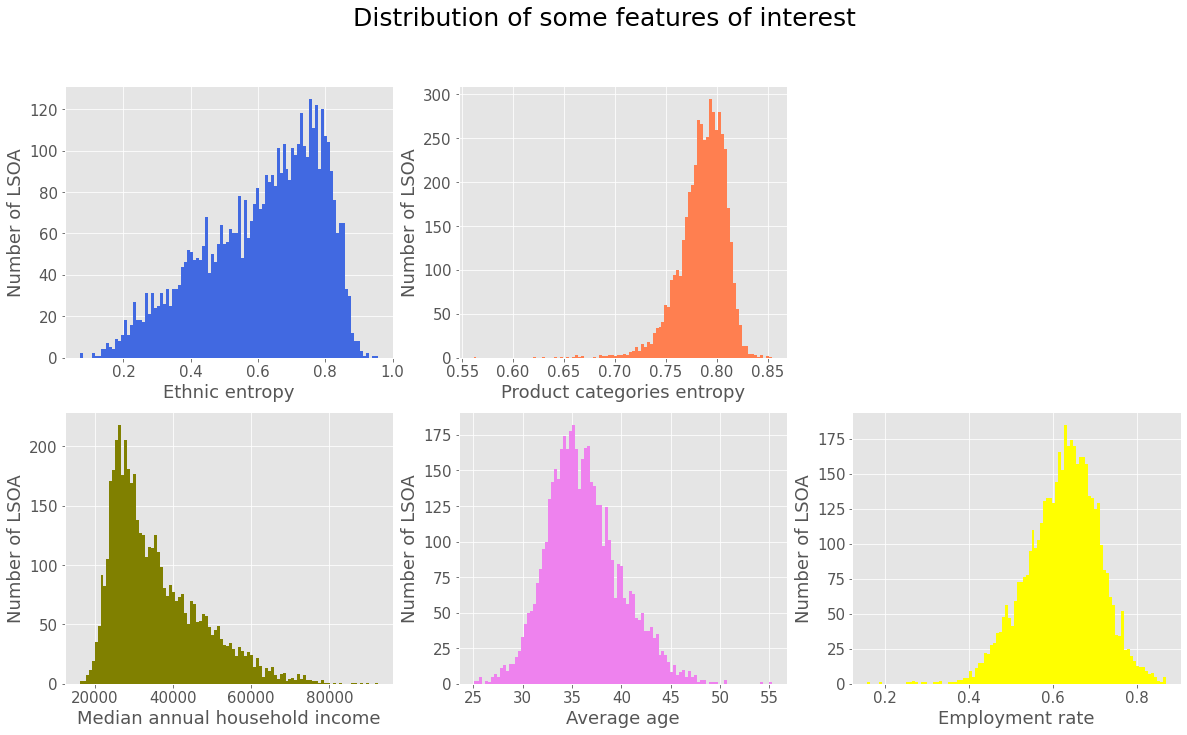

Ethnic entropy distribution: median = 0.644, mean = 0.612, std = 0.173


Product categories entropy distribution: median = 0.789, mean = 0.786, std = 0.023


Median annual household income distribution: median = 32609.000, mean = 35755.819, std = 11461.029


Average age distribution: median = 35.823, mean = 36.222, std = 3.755


Employment rate distribution: median = 0.631, mean = 0.624, std = 0.085




In [13]:
style.use('ggplot')

fig, ax = plt.subplots(2,3,figsize=(20,11))

plt.suptitle("Distribution of some features of interest", fontsize=25)

ax[0,0].hist(full_df['Ethnic_Group;h_ethnicities_norm;2011'], 100, color='royalblue')
ax[0,0].set_xlabel('Ethnic entropy', fontsize=18)
ax[0,0].set_ylabel('Number of LSOA', fontsize=18)
ax[0,0].tick_params(labelsize=15)

ax[0,1].hist(full_df['h_items_norm'], 100, color='coral')
ax[0,1].set_xlabel('Product categories entropy', fontsize=18)
ax[0,1].set_ylabel('Number of LSOA', fontsize=18)
ax[0,1].tick_params(labelsize=15)

ax[0,2].axis('off')

ax[1,0].hist(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)'], 100, color='olive')
ax[1,0].set_xlabel('Median annual household income', fontsize=18)
ax[1,0].set_ylabel('Number of LSOA', fontsize=18)
ax[1,0].tick_params(labelsize=15)

ax[1,1].hist(full_df['avg_age'], 100, color='violet')
ax[1,1].set_xlabel('Average age', fontsize=18)
ax[1,1].set_ylabel('Number of LSOA', fontsize=18)
ax[1,1].tick_params(labelsize=15)

ax[1,2].hist(full_df['Economic_Activity;Employment_ratio;2011'], 100, color='yellow')
ax[1,2].set_xlabel('Employment rate', fontsize=18)
ax[1,2].set_ylabel('Number of LSOA', fontsize=18)
ax[1,2].tick_params(labelsize=15)

plt.show()

print('Ethnic entropy distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['Ethnic_Group;h_ethnicities_norm;2011']),
              np.mean(full_df['Ethnic_Group;h_ethnicities_norm;2011']),
              np.std(full_df['Ethnic_Group;h_ethnicities_norm;2011'])))
print('\n')
print('Product categories entropy distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['h_items_norm']),
              np.mean(full_df['h_items_norm']),
              np.std(full_df['h_items_norm'])))
print('\n')
print('Median annual household income distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']),
              np.mean(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']),
              np.std(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)'])))
print('\n')
print('Average age distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['avg_age']),
              np.mean(full_df['avg_age']),
              np.std(full_df['avg_age'])))
print('\n')
print('Employment rate distribution: median = {0:1.3f}, mean = {1:1.3f}, std = {2:1.3f}'\
      .format(np.median(full_df['Economic_Activity;Employment_ratio;2011']),
              np.mean(full_df['Economic_Activity;Employment_ratio;2011']),
              np.std(full_df['Economic_Activity;Employment_ratio;2011'])))
print('\n')

We can see multiple interesting things. 
We first observe that the normalized ethnic entropy distribution spans almost accross the whole range of possible values (0 to 1). The distribution is also skewed toward larger entropy values. This means that our dataset present both area with high and low ethnic diversity, with ethnically diverse area being more represented.

The food products categories entropy distribution however shows a much smaller variance accross LSOA with a high mean value. 
With the rather large difference of variance of those two distributions, we can expect not to see dramatic effects on the product diversity when comparing areas featuring highly different ethnic diversity. This does not however mean that those effects will not be significant.

Looking at other socio-economic features that we suspect could play a role as confounders of our effect, we see that the median income distribution spans accross a large range of value with a 4 to 5 fold ratio between minimum and maximum values. The distribution is skewed toward lower values telling us that there are more areas with lower annual median income per household. 
The average age distribution looks like a normal distribution, as well as the employment rate distribution.

We can also see how our two main features of interest (the entropy of the distribution of the different ethnic groups and the entropy of the distribution of the different food products categories) are displayed geographically on a map of London.

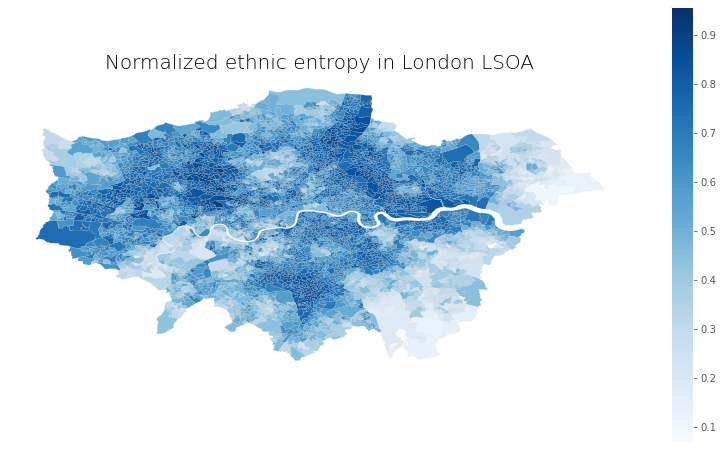

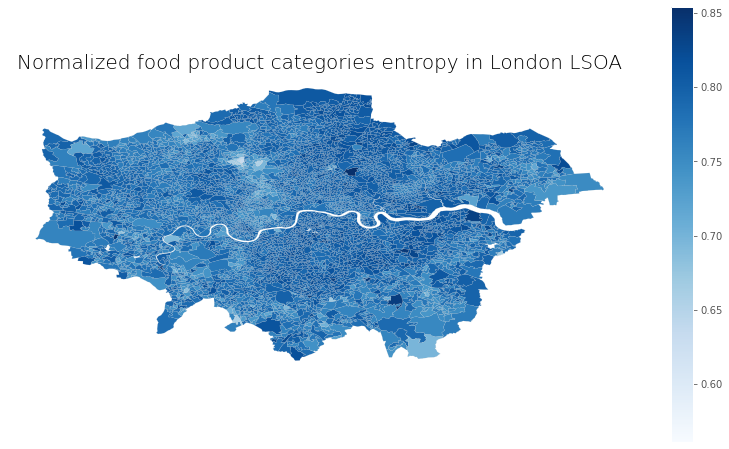

In [14]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Ethnic_Group;h_ethnicities_norm;2011'
# set the range for the choropleth
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 8))
vmin = np.min(full_df[variable])
vmax = np.max(full_df[variable])


# create map
full_df.plot(column=variable, cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8')
ax.axis('off')
# add a title
ax.set_title('Normalized ethnic entropy in London LSOA', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar as a legend
smap = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
smap._A = []
# add the colorbar to the figure
cbar = fig.colorbar(smap)

plt.show()


# set a variable that will call whatever column we want to visualise on the map
variable = 'h_items_norm'
# set the range for the choropleth
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 8))
vmin = np.min(full_df[variable])
vmax = np.max(full_df[variable])

# create map
full_df.plot(column=variable, cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8')
ax.axis('off')
# add a title
ax.set_title('Normalized food product categories entropy in London LSOA', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar as a legend
smap = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
smap._A = []
# add the colorbar to the figure
cbar = fig.colorbar(smap)

plt.show()

As expected after looking at the distributions of those two features, we can see a much greater variance in ethnic entropy. We can distinguish three main clusters of more ethnically diverse areas separated by less diverse ones. An interesting aspect of this representation is that we can see that while having a majority of more ethnically diverse areas, these areas tend to have a smaller surface.
The food product categories diversity is more even accross the whole London area.

---

## 4. Correlation analysis

To begin our analysis, we want to see if there are significant relations between the distributions of the different product categories and of the different ethnic groups represented in our dataset. We compute the Spearman rank correlation between those features at different level of granularity.

- Correlation between the normalized entropy of the product categories distribution and the normalized entropy of ethnic groups distribution
- Correlation between the different proportions of ethnic groups and the normalized entropy of the product category distribution
- Correlation between the different proportions of ethnic groups and different proportions of product categories

To assess the significance of those correlations, we use a Bonferroni corrected significance value of $\frac{\alpha}{n}$ where $\alpha = 0.05$ and $n$ is the number of different correlation computed in each of our test.

### 4.1. Correlation between ethnic diversity and product categories diversity

In [14]:
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011'].values
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values

rho_items, p_items = spearmanr(h_ethnicity, h_items)
rho_food, p_food = spearmanr(h_ethnicity, h_items_food)
rho_drink, p_drinks = spearmanr(h_ethnicity, h_items_drink)

d = {'Products': ['all','food', 'drink'],
     'R': [rho_items, rho_food, rho_drink],
     'p-value': [p_items, p_food, p_drinks]}
hh_corr_df = pd.DataFrame(data=d)
hh_corr_df

,Products,R,p-value
0,all,0.368818,1.285898e-155
1,food,0.286189,9.082810e-92
2,drink,0.192731,1.157947e-41


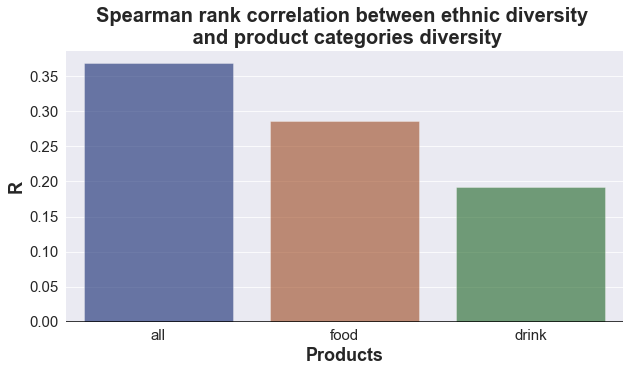

In [15]:
# keep only the significant data
n_test = 3
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
hh_plot_df = hh_corr_df[hh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Products', y='R', data=hh_plot_df, palette='dark', alpha=.6)
ax.grid(axis='y')
ax.set_ylabel('R', fontsize=18, fontweight='bold')
ax.set_xlabel('Products', fontsize=18, fontweight='bold')

#plt.xticks(rotation=90 )
ax.axhline(y=0, color='k', linestyle='-')
ax.set_title('Spearman rank correlation between ethnic diversity \n and product categories diversity',
             fontsize=20, fontweight='bold')
ax.tick_params(labelsize=15)
plt.show()

Value of the Spearman rank correlation (R) between the normalized entropy of the different ethnic groups distributions and the normalized entropy of all product categories distributions (left), the normalized entropy of the food-only product categories distributions (middle) and the normalized entropy of the drink-only product categories distribution (right). Only significative correlations with $p-value < \frac{0.05}{3}$ are reported. 

As we can see on this figure, there is a positive correlation between the ethnic diversity in an area and the diversity of products in the shopping carts. We can also see that the ethnic diversity is more correlated with food products diversity than with drinks.

### 4.2. Correlation between the different proportions of ethnic groups and product categories diversity

In [16]:
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1

# list containing the name of the ethnic groups
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) 
ethnic_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnic groups'])

n_ethnicity = ethnicity_col.shape[0]

# list containing the name of the item categories (food or drink)
category_col = np.array(['all',
                         'food',
                         'drink'])
n_category = category_col.shape[0]

# repeat elements to have same length and suitable format
ethnicity_col = np.repeat(ethnicity_col, n_category)
ethnic_col_short = np.repeat(ethnic_col_short, n_category)
category_col = np.tile(category_col, n_ethnicity)

# list containing the values of the ethnic group representations
f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)

# list containing the values of items entropy for food and drink
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values
h_item_categories = [h_items, h_items_food, h_items_drink]

# compute the correlation and their p-values
R_col = []
p_col = []
for et in f_ethnicities:
    for cat in h_item_categories:
        R, p = spearmanr(et, cat)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnic group': ethnic_col_short.tolist(),
     'Products': category_col.tolist(),
     'R': R_col,
     'p-value': p_col}

fh_corr_df = pd.DataFrame(data = d)
fh_corr_df

,Ethnic group,Products,R,p-value
0,White,all,-0.236992,1.109595e-62
1,White,food,-0.148771,2.537757e-25
2,White,drink,-0.155952,1.082312e-27
3,Mixed,all,0.441581,7.456270e-230
4,Mixed,food,0.310607,1.375516e-108
5,Mixed,drink,0.249160,2.676778e-69
6,Asian,all,-0.114748,1.227568e-15
7,Asian,food,-0.053519,1.974140e-04
8,Asian,drink,-0.078691,4.310637e-08
9,Black,all,0.572196,0.000000e+00


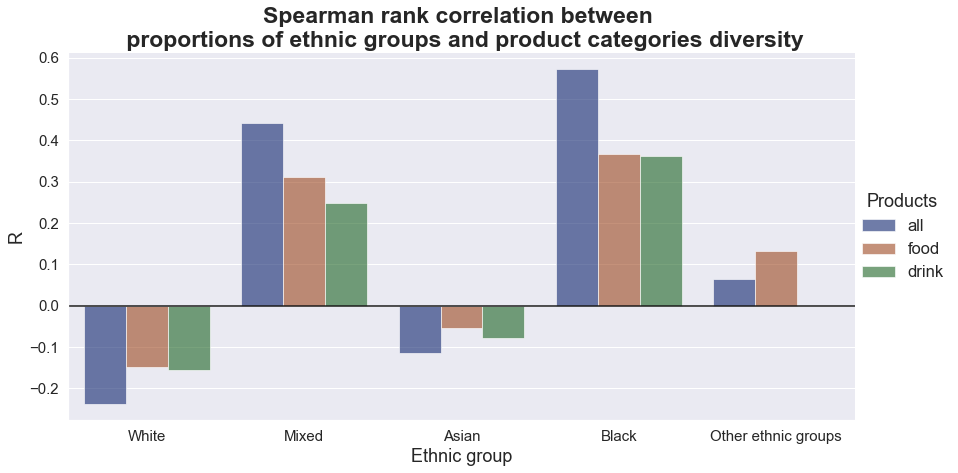

In [17]:
# keep only the significant data 
n_test = 15
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
fh_plot_df = fh_corr_df[fh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")
sns.set(font_scale=1.5)

g = sns.catplot(data=fh_plot_df, kind="bar", x="Ethnic group", y="R", hue="Products", palette="dark", 
                alpha=.6, height=6, aspect=2)

for ax in g.axes.flat:
    ax.grid(True, axis='y')
ax.axhline(y=0, color='k')

#plt.xticks(rotation=45 )

ax.tick_params(labelsize=15)

ax.set_title('Spearman rank correlation between \n proportions of ethnic groups and product categories diversity',
             fontsize=23, fontweight='bold')

plt.show()

Value of the Spearman rank correlation (R) between the proportions of the different ethnic groups and the normalized entropy of all product categories distributions, food-only product categories distribution and drink-only product categories distributions. Only significative correlations with $p-value < \frac{0.05}{15}$ are reported. 

From this figure, we can see that the proportions of the different ethnic groups correlates diferently with the products diversity. "Mixed" and "Black" ethnic groups show positive correlation, the "Black" ethnic group being the one featuring the largest positive correlation with product diversity. "White" and "Asian" ethnic groups show negative correlation, "White" ethnic group being the one with the most negative correlation value. The "Other" ethnic groups have a lower positive correlation value and is the only group to display a non significant correlation value (drinks). 

### 4.3. Correlation between the different proportions of ethnic groups and different proportions of product categories

In [18]:
# list containing names of the different products proportions
f_items_idx_lo = full_df.columns.get_loc('f_beer') 
f_items_idx_hi = full_df.columns.get_loc('f_wine')+1
item_col = np.array(full_df.columns[f_items_idx_lo:f_items_idx_hi]) # list containing name of the columns
n_item = item_col.shape[0]

# list containing names of the different ethnic groups
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) # list containing name of the columns
ethnicity_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnicities'])
n_ethnicity = ethnicity_col.shape[0]

# repeat elements to get good format
item_col = np.tile(item_col, n_ethnicity)
ethnicity_col = np.repeat(ethnicity_col, n_item)
ethnicity_col_short = np.repeat(ethnicity_col_short, n_item)


f_items = []
for col in full_df.iloc[:, f_items_idx_lo:f_items_idx_hi].columns:
    f_items.append(full_df[col].values)

f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)
    
R_col = []
p_col = []

for et in f_ethnicities:
    for item in f_items:
        R, p = spearmanr(et, item)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Item': item_col.tolist(),
     'R': R_col,
     'p-value': p_col}
      
ff_corr_df = pd.DataFrame(data = d)

# add a "Category column" to label items as food or drink
def is_food_or_drink(Item):
    
    food_list = set(['f_dairy',
                     'f_eggs',
                     'f_fats_oils',
                     'f_fish',
                     'f_fruit_veg',
                     'f_grains',
                     'f_meat_red',
                     'f_poultry',
                     'f_readymade',
                     'f_sauces',
                     'f_sweets'])

    drink_list = set(['f_beer',
                      'f_soft_drinks',
                      'f_spirits',
                      'f_tea_coffee',
                      'f_water',
                      'f_wine'])
    
    if Item in food_list :
        return "food"
    elif Item in drink_list :
        return "drink"

ff_corr_df.insert(1, 'Category', ff_corr_df['Item'].apply(is_food_or_drink), True)
ff_corr_df

,Ethnicity,Category,Item,R,p-value
0,Ethnic_Group;White_(ratio);2011,drink,f_beer,0.205189,4.187796e-47
1,Ethnic_Group;White_(ratio);2011,food,f_dairy,-0.273152,1.895280e-83
2,Ethnic_Group;White_(ratio);2011,food,f_eggs,-0.309786,5.383464e-108
3,Ethnic_Group;White_(ratio);2011,food,f_fats_oils,-0.426744,3.490461e-213
4,Ethnic_Group;White_(ratio);2011,food,f_fish,-0.013208,3.586075e-01
...,...,...,...,...,...
80,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_spirits,0.098075,8.323222e-12
81,Ethnic_Group;Other_ethnic_group_(ratio);2011,food,f_sweets,-0.239118,8.226865e-64
82,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_tea_coffee,0.110457,1.354980e-14
83,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_water,0.189520,2.553798e-40


We decided to display those correlation results into two different heatmaps (one for the food categories and one for the drink categories) for readability purposes.

<ipython-input-19-48a9cb06bb11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['R'][plot_df['p-value'] >= alpha_adj] = np.nan


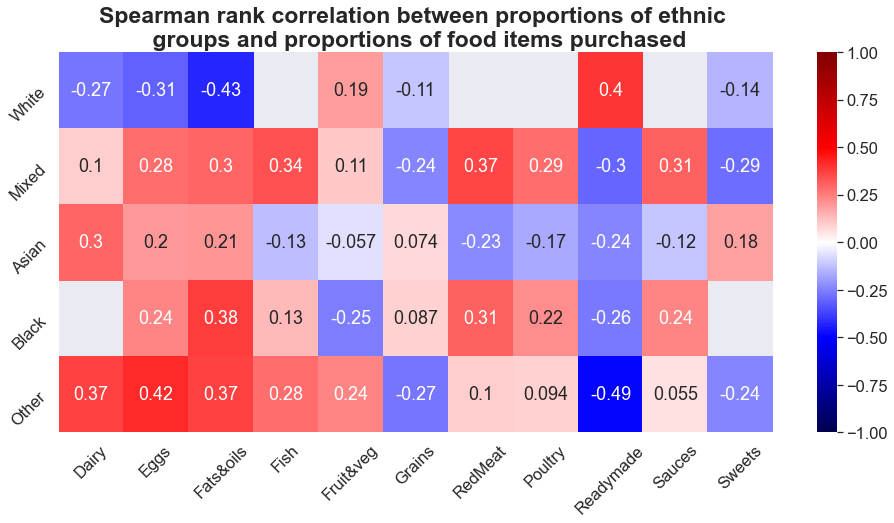

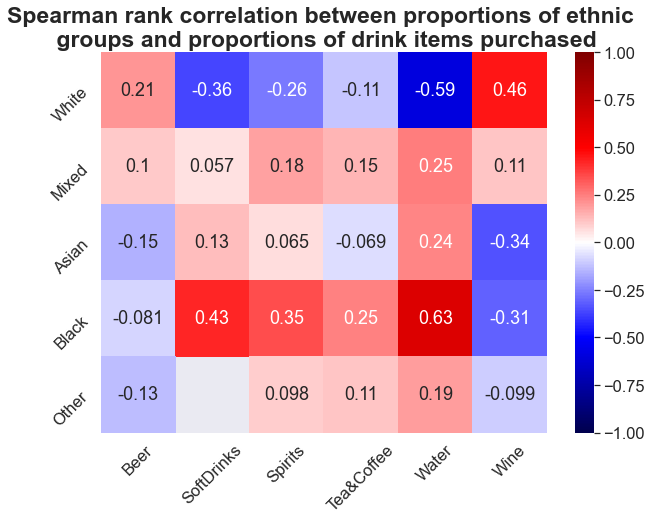

In [19]:
# keep only the significant data
n_test = 85
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
plot_df = ff_corr_df.copy()
plot_df['R'][plot_df['p-value'] >= alpha_adj] = np.nan
plot_df

ethnicity_list = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]).tolist()
n_ethnicity = len(ethnicity_list)
n_food = 11
n_drink = 6

R_food_np = np.zeros((n_ethnicity, n_food))
R_drink_np = np.zeros((n_ethnicity, n_drink))

for i in range(n_ethnicity):
    R_food_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'food')]
    R_drink_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'drink')]


ethnicities_list = ['White',
                    'Mixed',
                    'Asian',
                    'Black',
                    'Other']    
    
food_list = ['Dairy',
             'Eggs',
             'Fats&oils',
             'Fish',
             'Fruit&veg',
             'Grains',
             'RedMeat',
             'Poultry',
             'Readymade',
             'Sauces',
             'Sweets']

drink_list = ['Beer',
              'SoftDrinks',
              'Spirits',
              'Tea&Coffee',
              'Water',
              'Wine']


plt.figure(figsize=(16,7))
ax = sns.heatmap(R_food_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic \n groups and proportions of food items purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(food_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)

plt.figure(figsize=(10,7))
ax = sns.heatmap(R_drink_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic \n groups and proportions of drink items purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(drink_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)
plt.show()

Figures above show the correlations between the proportions of the different ethnic groups and the proportions of the different products in a heatmap. Positively and negatively correlated proportions are showed respectively in red and blue. Only significative correlations with $p-value < \frac{0.05}{85}$ are reported, non-significant correlations are represented as gray cells with no correlation values. 

With this level of granularity, we can see that the proportions of the different ethnic groups correlate differently to the proportions of specific food and drink products.
We can observe 6 non-significant values in the food-products heatmap and only one in the drink-products one. The "White" ethnic group is the one with the most non-significant correlated values, all present in the food-only products.
The largest correlation values in food-products (positive and negative) are respectively the correlation between "Other" ethnic group and "Eggs" category proportions (0.42) and the correlation between "Other" ethnic group  and "Readymade" category propotrions (-0.49). For the drink-products, the largest values are reached for correlation between "Black" ethnic group and "Water" category proportions (0.63) and for correlation between "White" ethnic group and "Water" category proportions (-0.59).

Those results can help to explain the correlation found in the previous figure.
We indeed see that ethnic groups that showed a more positive correlation with product categories diversity (Mixed, Black and Other) tend to have a majority of positively correlated values.
The two groups that showed a negative correlation with product categories diversity (White and Asian), present a majority of negatively correlated features. We can also note that the "White" ethnic group present the larger number of non-significant correlation values 

---

## 5. Causality analysis

We have seen that there exist correlations between purchased products diversity and ethnic diversity in LSOA, as well as between the proportions of some ethnicities and categories of items purchased. These are already encouraging results. However, the correlation between two features does not give any information about the causal link between them. For example, in some cases two features can be highly correlated, but because of the presence of one or more confounders, no causal link can be established. To dig deeper in the analysis of the effect of ethnic diversity on food purchase diversity, we will perform multiple tests aiming at demonstrating a causal effect of ethnic diversity on food purchase diversity.

We will start by a naive analysis using linear regressions to weight the impact of ethnic diversity and potential confounders on food purchase diversity. We will then use the notion of propensity score matching to be able to finally answer the main questions of this work.  

### 5.1. Naive initial analysis using Linear Regression

To get an idea of the effect of multiple features on food purchase diversity, we first performed a linear regression analysis. 

From our intuition, we selected features that we initially thought impacted food purchase diversity the most. We standardized them to be able to interpret better the weight of each feature selected on the output feature (`h_items_norm`).

In [20]:
employment_rate = full_df['Economic_Activity;Employment_ratio;2011']
employment_rate_stand = (employment_rate - np.mean(employment_rate))/np.std(employment_rate)

median_household_income = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
median_household_income_stand = (median_household_income - np.mean(median_household_income))/np.std(median_household_income)

avg_age = full_df['avg_age']
avg_age_stand = (avg_age - np.mean(avg_age))/np.std(avg_age)

h_items = full_df['h_items_norm']
h_items_stand = (h_items - np.mean(h_items))/np.std(h_items)

h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']
h_ethnicity_stand = (h_ethnicity - np.mean(h_ethnicity))/np.std(h_ethnicity)

We then build a dataframe containing the data that will be used in this part of the analysis.

In [21]:
lin_reg_df = pd.DataFrame()
lin_reg_df['employment_rate'] = employment_rate_stand
lin_reg_df['median_household_income'] = median_household_income_stand
lin_reg_df['avg_age'] = avg_age_stand
lin_reg_df['h_items'] = h_items_stand
lin_reg_df['h_ethnicity'] = h_ethnicity_stand
lin_reg_df.head()

,employment_rate,median_household_income,avg_age,h_items,h_ethnicity
LSOA11NM,,,,,
City of London 001A,1.465458,1.971130,3.214820,-1.382446,-1.378456
City of London 001B,1.453738,1.867475,2.976434,-1.104701,-1.896204
City of London 001C,0.563031,-0.119432,3.232598,0.359911,-0.798115
City of London 001E,-0.409714,-1.025721,-0.162352,-0.182977,0.927231
Barking and Dagenham 016A,-0.444873,0.295365,-1.102792,-0.245228,0.639302


First, we will try to keep only the ethnic entropy (`h_ethnicity`) to try to explain the food purchase entropy (`h_items`). We will use the statsmodels module.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['h_ethnicity'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     425.2
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           4.42e-89
Time:                        23:03:32   Log-Likelihood:                -4616.2
No. Observations:                3383   AIC:                             9236.
Df Residuals:                    3381   BIC:                             9249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0069      0.016      0.421      

---

We observe that 11.2% of the variance of `h_items` is explained by `h_ethnicity`, and that the effect is significant. We can now plot the predicted food product categories entropy in function of its true value. We see the spread from the identity which is associated to the $R^2$ value of 11.2%.

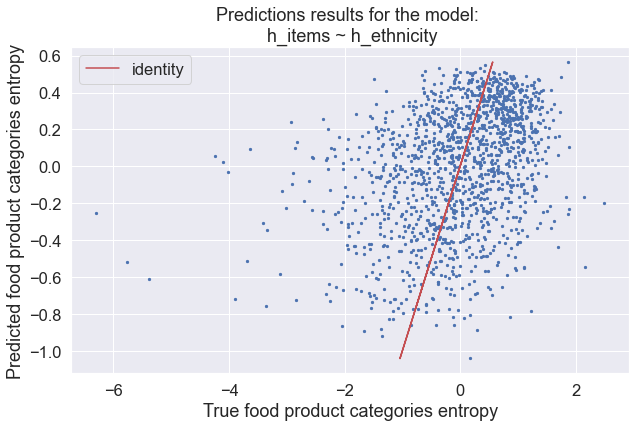

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, olsres.predict(X_test), s=5, c='b');
plt.plot(olsres.predict(X_test), olsres.predict(X_test), c='r', label='identity')
plt.legend()
plt.xlabel('True food product categories entropy')
plt.ylabel('Predicted food product categories entropy')
plt.title('Predictions results for the model: \n h_items ~ h_ethnicity')
plt.show()


We will now try to explain the variance in the food purchase entropy (`h_items`) with the following features of each LSOA:
- The ethnic entropy: `h_ethnicity`
- The employment rate: `employment_rate`
- The average age: `avg_age`
- The median income per household: `median_household_income`

The results will give us an idea about the contribution and significance of each term when predicting the value of `h_items`

In [24]:
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'employment_rate', 
                                                               'avg_age', 'median_household_income']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     181.2
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          7.46e-141
Time:                        23:03:32   Log-Likelihood:                -4487.8
No. Observations:                3383   AIC:                             8986.
Df Residuals:                    3378   BIC:                             9016.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

---

When adding the employment rate, the median household income and the average age of the LSOA's population in the predicting factors, $R^2$ only rises from 11.2 to 17.7 %. This seems to suggest that the ethnic entropy has a non-negligible effect on the food purchase category entropy. However, it is still a naive approach to the study of causality, and we will need to perform more sophisticated tests to ensure that confounders are not the cause for these results.

Let us plot again the predicted and true food purchase entropy, obtained from this second model.

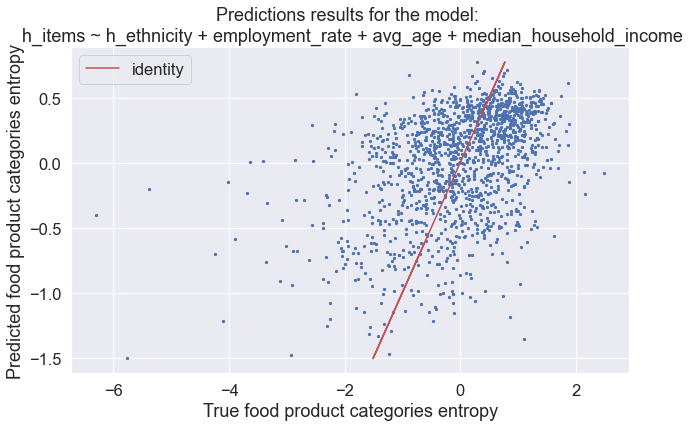

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, olsres.predict(X_test), s=5, c='b');
plt.plot(olsres.predict(X_test), olsres.predict(X_test), c='r', label='identity')
plt.legend()
plt.xlabel('True food product categories entropy')
plt.ylabel('Predicted food product categories entropy')
plt.title('Predictions results for the model: \n h_items ~ h_ethnicity + employment_rate + avg_age + median_household_income')
plt.show()

From these results using linear regressions, it looks like all four predictive factors have a significant effect on the food purchase entropy. They suggest the following conclusions:
- LSOA with more ethnic diversity tend to have a larger food purchase diversity
- LSOA with a higher employment rate tend to have a larger food purchase diversity
- LSOA with a higher average age tend to have a lower food purchase diversity
- LSOA with a larger median income per household tend to have a lower food purchase diversity

As the features are standardized, the magnitude of their coefficients can be directly compared. This suggests that `median_household_income` impacts `h_items` the most, followed by `h_ethnicity`, `employment_rate` and finally `avg_age`. Even though it seems that ethnic diversity has an effect on food purchase diversity in an LSOA, we still need to be careful with the conclusions we might take here. Indeed, we could be in a situation where for example the `median_household_income` feature is a confounder and therefore it influences both `h_items` and `h_ethnicity`. We could therefore see an effect of `h_ethnicity` on `h_items`, even though it is actually `median_household_income` which impacts both indirectly. In this case, the effect of `h_ethnicity` on `h_items` could entirely be explained by `median_household_income`. To ensure that we are not in such a situation, we will use the notion of matching. We will perform Generalized Propensity Score (GPS) matching. This will allow us to take into account and remove the effect of potential confounders in the analysis of the ethnic entropy's effect on food purchase entropy.

### 5.2. Propensity Score matching

#### 5.2.1. Towards propensity score matching with a continuous treatment feature

In the ADA course, we learned about propensity score matching. It is very useful to minimize the impact of confounders on the analysis of the effect of a feature (called the treatment) on another feature (called the output). Indeed, until now, we have focused on simple and naive correlations, giving no information about causality whatsoever, as well as linear regressions which only slightly bring a notion of causality in the analysis. To dig deeper in the analysis of the effect of ethnic diversity on food purchase diversity and to know if causality is involved here, we will perform a propensity score matching. The goal is to match samples together using a propensity score, which represents the probability that a sample has been treated (treatment value = 1, in opposition to 0 when not treated) based on the values of some of its other features (the ones used to compute the score). 

However, in the ADA course, propensity score matching was performed with a binary treatment feature. This makes it a lot easier. Indeed, by default it cuts the dataset in two groups whose respective samples can then be matched together. In this present case, the treatment we would like to study is the ethnic entropy, a continuous feature. As the dataset cannot really be cut in the same manner when using a continuous treatment feature, it is not as straightforward as the binary case. Of course, there is always the solution of binarizing the continuous feature. It can simply be done by setting a threshold in the treatment feature: the samples with a higher value form the first group and the samples with an equal or lower value form the second group. This solution has a critical drawback though: it makes it very difficult to interpret the results of the treatment effect. Indeed, if the matching works well, and in the end a significant effect is found, it means the following thing: if a sample belongs to the first group, the output feature is significantly larger/lower (depending on the effect of the treatment) than it would be if this sample was in the second group (and therefore if its treatment was lower). Let us say that the threshold is set such that the two resulting groups have the same size. As groups are formed via a threshold on a continuous feature, it means that being in the top 50 % of samples in terms of the treatment feature value impacts a sample's output feature. But what about a sample at 49 % compared to one at 51 %? Is there really such a hard boundary? In most cases, no. Indeed, the threshold is often arbitrary in the case of a continuous feature. 

To account for the fact that the treatment feature is continuous, we decided to use an implementation of **Generalized Propensity Score (GPS)** matching. Matching is performed on two values: the propensity score of the sample, computed using a regression on the features selected to build the score (potential confounders whose effect needs to be minimized), and its continuous treatment value. Similar samples on these two values are matched together. The output of the algorithm is called a Causal Dose Response (CDR) curve. It computes the effect of the treatment on the output by calculating the predicted output value in function of the treatment value. If the treatment has an effect, then the curve is not flat, i.e. the predicted output changes depending on the treatment. The GPS algorithm outputs a confidence interval and we can use it to assess the significance of the resulting CDR curve.

First, we need to filter the full dataset once again to keep only the numerical features for our general propensity analysis

We start by removing all the non-numerical data of the dataset such as the geographical informations and the names of the areas.
Since we want to use our ethnic entropy as treatment, we can remove the informations about the proportions of the different ethnic groups. Those features are indeed highly correlated with the entropy as they are used to compute it.
Following the same reasoning, we can also remove all features related to the proportions of the item categories since they are used to compute the entropy of the items that we are using as outcome of our study.

Finally, we can drop several other features. Some of the data in our dataset represent proportions for distributions of only 2 outcomes (e.g. employement rate & unemployement rate). Since each time this happened those two features will obviously be extremely correlated, we choose to keep only one of the two.

In [26]:
filtered_df = full_df.loc[:, 'h_items_norm':'people_per_sq_km']
filtered_df = pd.concat([ filtered_df, full_df.loc[:, 'Households;All_households;2011':'h_household_compo_norm']], axis=1)
filtered_df = pd.concat([ filtered_df, full_df.loc[:, 'Ethnic_Group;h_ethnicities_norm;2011':]], axis=1)
filtered_df.drop(['Country_of_Birth;ratio_Not_United_Kingdom;2011'], axis=1, inplace=True)
filtered_df.drop(['Household_Language;ratio_of_households_where_no_people_aged_16_or_over_have_English_as_a_main_language;2011'], axis=1, inplace=True)
filtered_df.drop(['Economic_Activity;Unemployment_ratio;2011'], axis=1, inplace=True)

print(filtered_df.shape)
filtered_df.sample(5)

(4833, 82)


,h_items_norm,representativeness_norm,transaction_days,num_transactions,man_day,population,male,female,age_0_17,age_18_64,...,Health;Bad_or_Very_Bad_health_(ratio);2011,h_health_state_norm,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,h_car_avail_norm,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
Wandsworth 017A,0.782320,0.237233,364.0,182847.0,12174.0,1705.0,877.0,828.0,411.0,1100.0,...,0.016,0.265966,0.214,0.545,0.180,0.051,0.010,0.725239,103268.0,75593.0
Waltham Forest 021E,0.793327,0.493008,364.0,722942.0,46151.0,1771.0,989.0,782.0,318.0,1328.0,...,0.032,0.411732,0.418,0.455,0.099,0.025,0.003,0.659550,51284.0,41464.0
Redbridge 004C,0.810538,0.253947,364.0,92735.0,6879.0,1787.0,885.0,902.0,422.0,1140.0,...,0.062,0.555143,0.366,0.469,0.130,0.029,0.006,0.696875,35727.0,28252.0
Wandsworth 025D,0.782338,0.155603,364.0,28552.0,4794.0,1764.0,823.0,941.0,311.0,1363.0,...,0.017,0.276483,0.381,0.522,0.084,0.011,0.001,0.603672,71004.0,52046.0
Greenwich 002A,0.815690,0.190436,364.0,135787.0,13784.0,1688.0,1049.0,639.0,329.0,1234.0,...,0.074,0.565200,0.434,0.468,0.076,0.018,0.004,0.626221,34237.0,26362.0


We then standardize the dataset. Indeed, each feature is continuous and therefore we can directly perform it on the whole dataframe.

In [27]:
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()
std_df.sample(5)

,Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Country_of_Birth;ratio_United_Kingdom;2011,"Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011",Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011,Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011,...,h_qualif_norm,h_religion_norm,h_tenure_norm,male,man_day,num_transactions,people_per_sq_km,population,representativeness_norm,transaction_days
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
Newham 027B,1.082841,-0.919329,-0.863841,-0.761345,-0.830161,1.035041,-0.884199,0.433173,0.878238,-0.878247,...,1.016751,-0.337734,-0.074286,0.534349,-0.076632,0.020782,-0.333636,0.170926,0.059145,0.325182
Hammersmith and Fulham 013D,0.571070,-2.146548,-1.178668,-0.960735,-0.263253,1.720927,-0.428768,1.147303,0.481807,-0.481829,...,0.483127,-0.256175,-1.604472,-1.313629,-0.141855,-0.215736,0.110100,-1.187107,0.238078,0.325182
Lewisham 022E,-0.196587,0.821317,-0.132629,-0.063479,-0.020293,-0.271921,0.123271,-0.865863,0.847743,-0.847753,...,0.501774,-0.479015,0.400000,-0.138556,0.796413,1.013781,0.216735,-0.075989,1.102896,0.325182
Wandsworth 020F,-0.708358,1.222041,0.202509,0.235606,-0.182266,-0.660769,-0.180350,-0.161935,0.176860,-0.176892,...,-0.805184,-0.330220,0.881549,-0.449900,-0.389151,-0.556627,-0.523075,-0.429900,-0.262138,0.325182
Sutton 012E,-0.452472,0.908976,0.202509,0.002984,-0.020293,-0.493348,1.047934,0.157723,0.664775,-0.664791,...,0.276669,-1.296243,0.459500,0.223005,-0.795417,-0.763753,-0.470738,0.376689,-0.800134,0.325182


The goal is now to select the features that we want to use in the propensity score, because we do not want to use all the features in the current dataframe. The output feature (i.e. the one we want to predict in the end) is the standardized version of `h_items_norm`, and we will therefore compute the Spearman correlation between this feature and all the other features. This is our way of filtering the features that will be used to compute the propensity score. Indeed, the goal is to include the features that are most likely to be confounders for the effect of ethnic diversity on food purchase diversity.

In [28]:
n_features = std_df.shape[1]

correl_df = pd.DataFrame(0, index=range(n_features-1), columns=['feature', 'correlation', 'p_value'])
feature_list = std_df.columns.tolist()
feature_list.remove('h_items_norm') 
correl_df['feature'] = feature_list

for i, col in enumerate(feature_list):
    correl, pval = spearmanr(std_df['h_items_norm'], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval

correl_df.head()

,feature,correlation,p_value
0,Adults_in_Employment;ratio_of_households_with_...,0.402207,2.178904e-187
1,Car_or_van_availability;1_car_or_van_in_househ...,-0.127561,5.479353e-19
2,Car_or_van_availability;2_cars_or_vans_in_hous...,-0.328573,4.965303e-122
3,Car_or_van_availability;3_cars_or_vans_in_hous...,-0.307831,1.359370e-106
4,Car_or_van_availability;4_or_more_cars_or_vans...,-0.305167,1.066943e-104


Let us now discard the features for which the correlation with the output feature is not significant (i.e. their associated p-value > $\frac{0.05}{N}$ with $N$ the number of tests performed).

In [29]:
# keep only the significant data
# Bonferroni adjusted alpha
n_test = len(correl_df)
alpha_adj = 0.05/n_test

filtered_correl_df = correl_df[ correl_df['p_value'] < alpha_adj ]

filtered_correl_df.shape

(73, 3)

Let's now sort the features from the most to the least correlated to `h_items_norm`, using the absolute value of the correlation coefficent.

In [30]:
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
sorted_correl_df.head(10)

,feature,correlation,abs_correlation,p_value
29,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.453982,1.938682e-244
16,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.425294,1.344982e-211
54,Tenure;Owned_outright_(ratio);2011,-0.415181,0.415181,9.295447e-201
57,Tenure;Social_rented_(ratio);2011,0.412346,0.412346,8.727722e-198
0,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.402207,2.178904e-187
28,Household_Composition;ratio_Couple_household_w...,-0.378579,0.378579,1.593143e-164
70,h_household_compo_norm,0.369545,0.369545,2.856378e-156
18,Ethnic_Group;h_ethnicities_norm;2011,0.368818,0.368818,1.285898e-155
32,"Household_Income,_2011/12;Mean_Annual_Househol...",-0.352765,0.352765,1.258317e-141
33,"Household_Income,_2011/12;Median_Annual_Househ...",-0.351866,0.351866,7.241041e-141


Let's keep the top $M$ features in terms of absolute correlation with the food purchase entropy for the Generalized Propensity Score computation. In this case, to simplify the readability and level of interpretation of the following results, we will use $M$ = 10. After that, we will modularize this whole procedure, and we will be able to test other values of $M$. The top 10 features are printed below.

In [31]:
main_features = sorted_correl_df.head(10)['feature'].tolist()

print('Features most correlated (absolute value) to entropy of items category: \n')
for el in main_features:
    print(el)
    
print('\n')

Features most correlated (absolute value) to entropy of items category: 

Household_Composition;ratio_Lone_parent_household;2011
Economic_Activity;Economically_active:_Unemployed;2011
Tenure;Owned_outright_(ratio);2011
Tenure;Social_rented_(ratio);2011
Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011
Household_Composition;ratio_Couple_household_without_dependent_children;2011
h_household_compo_norm
Ethnic_Group;h_ethnicities_norm;2011
Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)
Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)




The 10 features with the largest correlations with the standarized `h_items_norm` are printed above. It turns out that the treatment feature (the ethnic entropy) is among the features kept. If it was not the case, it would not be a problem. However, it is encouraging for the rest of the analysis.

Let us take this opportunity to briefly describe these important features:
- `Household_Composition;ratio_Lone_parent_household;2011`: the proportion of households with lone parents
- `Economic_Activity;Economically_active:_Unemployed;2011`: the proportion of econonmically active people which are unemployed
- `Tenure;Owned_outright_(ratio);2011`: the proportion of tenure that are owned
- `Tenure;Social_rented_(ratio);2011`: the proportion of tenure that are social rented
- `Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011`: out of all households with no adults employed, it represents the proportion that have dependent children
- `Household_Composition;ratio_Couple_household_without_dependent_children;2011`: the proportion of households which consist in a couple without dependent children
- `h_household_compo_norm`: the entropy of household compositions, which can either be:
    - Couple household with dependent children
    - Lone parent household
    - One person household
    - Other multi-person houshold
- `Ethnic_Group;h_ethnicities_norm;2011`: the entropy of the ethnicity, which is the treatment feature
- `Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)`: the mean annual household income estimate, in pounds
- `Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)`: the median annual household income estimate, in pounds

These features will be used to determine if ethnic diversity has a causal effect on food purchase diversity.

Let us add the food product categories entropy to the list and then generate a dataframe for the GPS matching.

In [32]:
main_features.append('h_items_norm')
features_df = std_df[main_features]

For simplicity sake, we give those features more manageable names.

In [33]:
features_df = features_df.rename(columns={"Household_Composition;ratio_Lone_parent_household;2011": "lone_parents",
                            "Economic_Activity;Economically_active:_Unemployed;2011": "unemployed", 
                            "Tenure;Owned_outright_(ratio);2011": "owned_tenure",
                            "Tenure;Social_rented_(ratio);2011": "social_rented_tenure",
                            "Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011":
                            "households_no_adults_employed",
                            "Household_Composition;ratio_Couple_household_without_dependent_children;2011": 
                            "couple_household_no_children",
                            "Ethnic_Group;h_ethnicities_norm;2011": "h_ethnic",
                            "Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)": "household_mean_income", 
                            "Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)": "household_median_income"})

---

#### 5.2.2. Generalized Propensity Score (GPS) matching

We will now perform the Generalized Propensity Score (GPS) matching. We found it already implemented online (https://causal-curve.readthedocs.io/en/latest/intro.html) and decided to use it as is. We will ensure to compare multiple results to confirm that it is useful in the current analysis. 

We will use the ethnic entropy as the treatment feature, and the food product categories entropy as the output feature.

After some initial experiments, we found good parameters to run this algorithm. The `treatment_grid_num` parameter controls the discretization of the treatment feature value. `lower_grid_constraint` and `upper_grid_constraint` control the lower and upper quantiles between which the matching is performed. Indeed, we realized that by using all the values, the results can get biased, as the density of datapoints of ethnic entropy (the treatment feature) is lower near the minimum and maximum values of the feature. By setting this interval as 0.2-0.8, we capture 60% of data, where it is densed enough to perform matching. In other cases, using 0.05-0.95 and capturing 90% of the data is feasible, but in this dataset we do not have enough datapoints (LSOA) for this. The other parameters are set as default.

In [34]:
gps = GPS(gps_family=None,
          treatment_grid_num=100,
          lower_grid_constraint=0.2,
          upper_grid_constraint=0.8,
          spline_order=3,
          n_splines=15, # maximum number of turning points (knots) to be used during the smoothing process
          lambda_=0.5,
          max_iter=500,
          random_seed=None,
          verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')
#features.remove('h_ethnic')

treat_feat = 'h_ethnic'
features.remove(treat_feat)

# Fits the causal dose-response model.
gps.fit(T = features_df[treat_feat], 
        X = features_df[features], 
        y = features_df['h_items_norm'])

gps_results = gps.calculate_CDRC(0.95)

We will now plot the output of the GPS matching, which gives information about the treatment (i.e. ethnic entropy) effect on the output (i.e. the food purchase entropy).

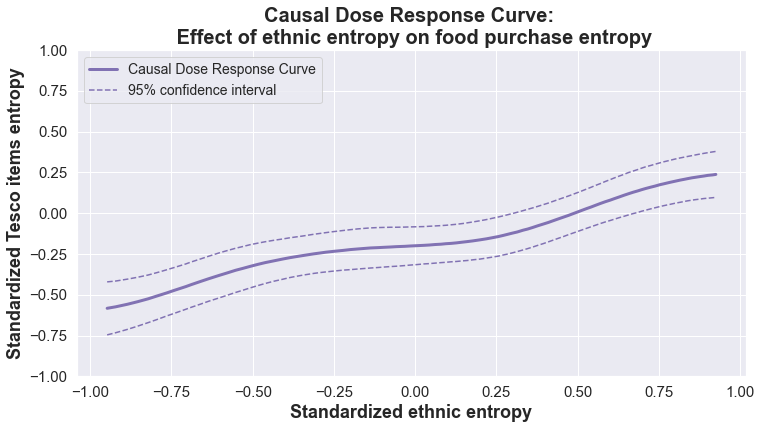

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve: \n Effect of ethnic entropy on food purchase entropy',
          fontsize=20, fontweight='bold')
plt.xlabel('Standardized ethnic entropy', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

plt.tick_params(labelsize=15)

plt.legend(loc=2, prop={'size': 14})

plt.show()

The y-axis represents the standardized food product categories entropy and the x-axis the standardized ethnic entropy. Therefore, we get the value of the output feature plotted in function of the treatment's feature value. This plot is quite intuitive to interpret: when the ethnic entropy increases, so does the food product categories entropy. We observe that the confidence interval (CI) gives us information about the significance of the causal effect of the ethnic entropy on the food product categories entropy. Indeed, intuitively we understand that the treatment effect on the output would not be significant if a horizontal line could be drawn fully inside the CI (more on this in the next paragraphs). A horizontal line represents a null treatment effect: the output has the same expected value no matter what the treatment value is. In this case, it is clear that no horizontal line can be fully contained in the CI, and therefore ethnic entropy seems to have a significant positive causal effect on food product categories entropy. Before interpreting this result, we will first derive a metric from the CDR curve which encompasses the notion of causality significance, and we will then modularize the code to ensure that the results hold when more confounding factors are taken into account.

---

#### 5.2.3. Deriving a metric to measure the signficance of the treatment effect

To measure the significance of the treatment feature on the output feature, we thought about a metric. It is quite straightforward and surely it already exists, but we have not been able to find anyone else using or defining it.

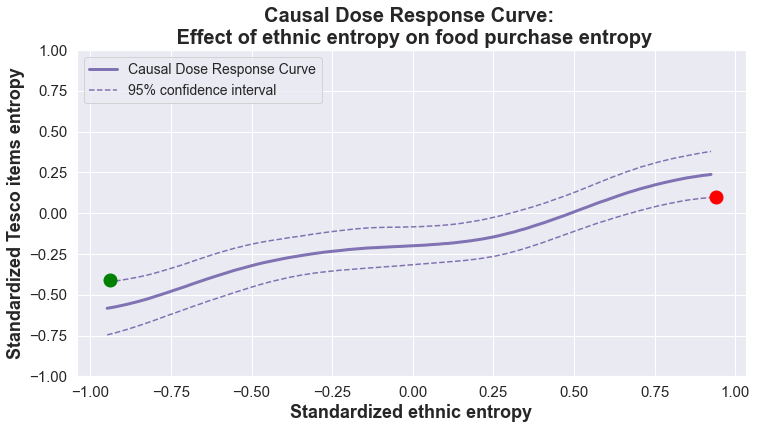

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve: \n Effect of ethnic entropy on food purchase entropy',
          fontsize=20, fontweight='bold')
plt.xlabel('Standardized ethnic entropy', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

# plot points to highlight how the metric we will use works
plt.plot([-0.94], [-0.41], marker='o', markersize=13, color="green")
plt.plot([0.94], [0.1], marker='o', markersize=13, color="red")

plt.tick_params(labelsize=15)

plt.legend(loc=2, prop={'size': 14})

plt.show()

Let us look at the plot above to define this metric on a concrete example. It is exactly the same plot as presented above, but we added visual clues to derive the metric more easily. In this case, the CDR curve has an approximately constant positive slope. We observe that no horizontal line can be drawn inside the confidence interval (CI). As a horizontal line corresponds to the treatment having no effect on the output, in the case of the curve above we interpret that the effect of the treatment on the output is significant.

Now, how can we capture this information using a simple and robust metric? If we look at the difference between the maximum value of the lower CI (y value of the red dot on the plot) and the minimum value of the upper CI (y value of the green dot), we observe that in this case it is positive. Indeed, the red dot has a larger y-value (standarized food purchase entropy) than the green dot. By definition, this difference being positive verifies that no horizontal line can be drawn inside the CI. Since we took the 95% CI, not being able to draw a horizontal line fully contained within the CI ensures that there is less than 5% chance of wrongly rejecting the null hypothesis (type I error) that the treatment effect is null (i.e. the treatment has no effect on the output).  

Here is the value of the metric in this case:

In [37]:
treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of 0.518.


There we have it: the GPS matching results suggest that ethnic diversity indeed has an effect on food product categories diversity.

Let us compare this example to another one, to better grasp how this metric works. Here is the CDR curve, with the number of male in the area as a treatment feature.

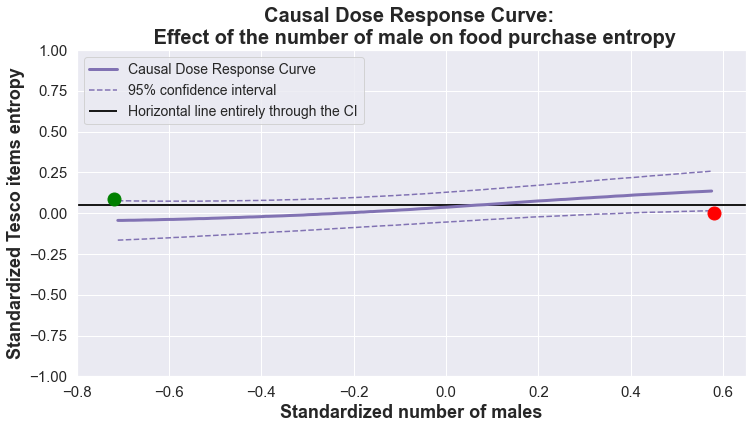

In [38]:
gps = GPS(gps_family=None, treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, spline_order=3,
          n_splines=15, lambda_=0.5, max_iter=500, random_seed=None, verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')

treat_feat = 'male'

gps.fit(T = std_df[treat_feat], X = features_df[features], y = features_df['h_items_norm'])
gps_results = gps.calculate_CDRC(0.95)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve', c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.plot([-0.72], [0.09], marker='o', markersize=13, color="green")
plt.plot([0.58], [0], marker='o', markersize=13, color="red")
plt.hlines(0.05, -1, 1, color='k', linewidth=2, label='Horizontal line entirely through the CI')

plt.title('Causal Dose Response Curve: \n Effect of the number of male on food purchase entropy', fontsize=20, fontweight='bold')
plt.xlabel('Standardized number of males', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

ax.legend()
plt.ylim(-1,1)
plt.xlim(-0.8,0.65)
plt.tick_params(labelsize=15)
plt.legend(loc=2, prop={'size': 14})

plt.show()

We can observe that in this case, the green dot has a larger y-value compared to the red dot, in turn meaning that the metric is negative. It is clear that a horizontal line can be drawn inside the CI, as shown by the black line; therefore we rate the effect of this treatment as non significant.

In [39]:
treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of -0.059.


The more positive this metric is, the more significant is the effect of the treatment. We do not need to normalize it, as we are already working with a standardized dataframe. In the two examples presented, the max of the lower CI and the min of the upper CI are on the bounds of the interval. Even when this is not the case, the metric still works just fine. Indeed, if we imagine a parabolic CDR curve, the metric will still be negative if a horizontal line can be drawn in the CI, and positive if not. 

This metric is really interesting thanks to the visual intuition it represents and to its simplicity. However, it two slight drawbacks: it cannot retrieve the sign of the causal effect and it cannot always capture the magnitude of the treatment effect on the output. Indeed, if the CDR curve is not well estimated by a linear regression (i.e. if it does not look like a line), the value of the _causality significance metric_ could minimize the effect of the treatment. It will always be proportional to the difference between the highest estimated output value in function of the treatment, and its lowest estimated value (because the CI englobes the CDR curve and follows its variations), which is already interesting enough to give an idea of treatment effect magnitude.

---

#### 5.2.4. Modularity

We have now seen in details with the ethnic and food purchase entropies, how we can analyze those features to go from a correlation, telling us how strong the association between the two variables is, to a causality link between them. 
Let's create some functions to perform those analyses in a more condensed way, allowing us to test the causality link between many features appearing to be correlated or not.

To do so, we will use two functions.
- `compute_corr_df()`: Returns a standardized dataframe of the $M$ most correlated features to an outcome feature, as well as a dataframe with the same features but not standardized
- `compute_GPS()`: Compute the Generalized Propensity Score between a treatment and an outcome feature, considering all the other features present in the dataframe as confounding factors. Returns our causality metric as well as the points of the causal dose response curve

In [40]:
##### Function to determine the most correlated features #####
def compute_corr_df(df, treatment_name, outcome_name, M=30, alpha=0.05):
    '''
    Standardize the df
    Compute the correlation between each features of the df and the outcome feature
    Select the significative correlations (for alpha)
    Return a df of only the n most correlated features & the outcome feat
    (& the treatment if not in the most correlated features) 
    Return another df, that is similar but not standardized
    '''
    
    # standardize the df
    std_df = (df - df.mean()) / df.std()
    
    correl_df = pd.DataFrame(0, index=range(df.shape[1]-1), columns=['feature', 'correlation', 'p_value'])
    features = list(df.columns.values)
    features.remove(outcome_name)  
    correl_df['feature'] = features
    
    # compute the correlation on the standardized df
    for i, col in enumerate(features):
        correl, pval = spearmanr(std_df[outcome_name], std_df[col])
        correl_df.loc[i, 'correlation'] = correl
        correl_df.loc[i, 'p_value'] = pval
        
    alpha_adj = alpha/len(correl_df)
    filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
    filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
    sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
    
    main_features = sorted_correl_df.head(M)['feature'].tolist()
    main_features.append(outcome_name)
    
    ## Check if the treatment is one of the most correlated features, otherwise add it
    if not treatment_name in main_features:
        main_features.append(treatment_name)
    
    corr_features_df = df[main_features]
    std_corr_features_df = std_df[main_features]
    
    return corr_features_df, std_corr_features_df



##### Function to compute the Generalized propensity Score #####

def compute_GPS(df, std_df, treatment_name, outcome_name, plot_std=False, plot_normal=False, CI=0.95, 
                ymin_std=-1, ymax_std=1):
    '''
    Compute the generalized propensity score to determine the Causal Dose Response Curve
    between the treatment and the outcome, considering the other features of the df as confounders
    '''
    gps = GPS(treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, n_splines=15)
    
    features = std_df.columns.to_list()
    features.remove(treatment_name)
    features.remove(outcome_name)

    # Fits the causal dose-response model.
    gps.fit(T = std_df[treatment_name], 
            X = std_df[features], 
            y = std_df[outcome_name])
    
    gps_results = gps.calculate_CDRC(CI)
    
    if plot_std:
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], 
                 label='Causal Dose Response Curve', linewidth=3)
        plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'k--', label='95% confidence interval')
        plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'k--')
        plt.ylim(ymin_std,ymax_std)
        plt.xlim(-1,1)
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Standardized Treatment: ' + treatment_name)
        plt.ylabel('Standardized Outcome: ' + outcome_name)
        plt.show()
        
    if plot_normal:
        
        # destandardize the values
        treat_destd = gps_results['Treatment']*np.std(df[treatment_name]) + np.mean(df[treatment_name])
        
        std_out = np.std(df[outcome_name])
        mean_out = np.mean(df[outcome_name])
        cdr_destd = gps_results['Causal_Dose_Response']*std_out + mean_out
        cdr_destd_low95 = gps_results['Lower_CI']*std_out + mean_out
        cdr_destd_up95 = gps_results['Upper_CI']*std_out + mean_out
        
        #plot
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(treat_destd, cdr_destd, label='Causal Dose Response Curve',linewidth=3)
        plt.plot(treat_destd, cdr_destd_low95, 'k--', label='95% confidence interval')
        plt.plot(treat_destd, cdr_destd_up95, 'k--')
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Treatment: ' + treatment_name)
        plt.ylabel('Outcome: ' + outcome_name)
        plt.show()
    
    treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
    
    return gps_results, treatment_effect_metric


### 5.3. Assessing our approach

#### 5.3.1. Impact of the number of features used to compute the propensity score

We have observed that using the 10 features being the most correlation with the outcome feature (i.e. food purchase entropy) to compute the propensity score results in a significant treatment (i.e. ethnic entropy) effect. However, the choice of considering only the 10 most correlated features as potential confounders is arbitrary. Therefore, let's check that this arbitrary choice has no influence on the conclusion drawn by looking at the causality significance metric that is obtained when considering a different value of $M$ (i.e. the value controlling the number of top correlated features that are used as confounding factors in the GPS matching procedure). We will test values ranging from $M = 1$ to $M = 50$.

In [41]:
nb_corr_feat = range(1, 51)
caus_metric = []
treat_feat = 'Ethnic_Group;h_ethnicities_norm;2011'

for nb in nb_corr_feat:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm', M=nb)
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

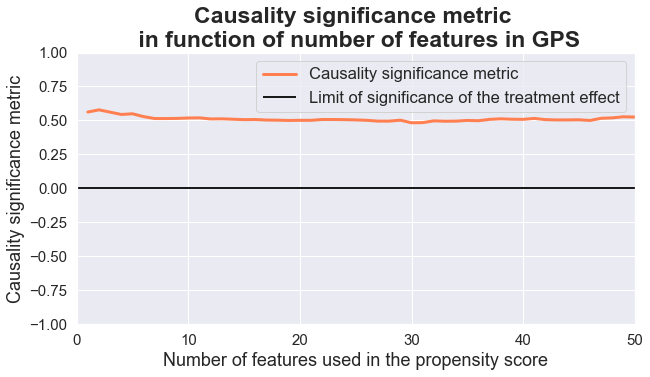

In [42]:
plt.figure(figsize=(10,5))

plt.plot(nb_corr_feat, caus_metric, linewidth=3, color='coral', label='Causality significance metric');
plt.hlines(0, -5, 65, colors='k', linewidth=2, label='Limit of significance of the treatment effect')

plt.title('Causality significance metric \n in function of number of features in GPS', fontsize=23, fontweight='bold')
plt.xlabel('Number of features used in the propensity score', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(-1,1);
plt.xlim(0,50)

plt.legend()
plt.show()

The causality significance metric does not change when considering more correlated features as potential confounders. This suggests that considering only the 10 most correlated features is enough to determine the causality significance between the treatment and the outcome, removing the effect of potential confounders. It is quite interesting, as it seems that the number of confounding factors used does not impact the causality significance of the ethnic diversity on the food purchase diversity. This suggests that the ethnic diversity does not have any real confounders in this dataset.

As GPS matching accounts for potential confounders in the dataset, we can conclude that a London LSOA with more ethnic diversity tends to have a higher food purchase diversity. Even though not all potential confounders are present in our dataset, we can still be confident that this result would be significant when adding other factors in the computation of the GPS score. Indeed, as we will see in the next part of the causality anaylsis, the causality significance of the ethnic entropy's effect on the food purchase entropy is the 3rd highest in the current dataset. This means that the result is very significant, and as we believe that most of the main potential confounders are present in the dataset, it strongly suggests that this effect is significant overall. However, let us not forget that the results are regarding London LSOA and considering only Tesco purchases, and therefore we cannot predict if they would still hold in other parts of the globe, using data from other supermarkets.

To ensure that this example is not an exception and that we are considering enough potential confounders for each analysis, for the following analyses we will take into account the 30 most correlated features to the outcome as potential confounders of the treatment.

#### 5.3.2. Link between causality and correlation results

Now let's check that not all the features correlated to the food purchase diversity appear to have a causality link with this latter. If it was the case, then it would mean that something went wrong in our analysis as we aim to identify what are the real causal links that can be observed from the correlated features and not just having another metric that is similar to the correlation. We will therefore perform GPS matching with $M = 30$ with each feature of the dataframe used in this causality analysis section as a treatment. In each case, we keep the food purchase entropy as the ouput feature. We will compute the causality significance in each case, and we will then be able to compare its value with the correlations computed in the correlation analysis section.

In [43]:
## First determine all the features correlated to the diversity in food purchase
## and their correlation value
outcome_name = 'h_items_norm'

# standardize the df
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()

correl_df = pd.DataFrame(0, index=range(filtered_df.shape[1]-1), 
                         columns=['feature', 'correlation', 'p_value'])

features = list(filtered_df.columns.values)
features.remove(outcome_name)  
correl_df['feature'] = features

# compute the correlation on the standardized df
for i, col in enumerate(features):
    correl, pval = spearmanr(std_df[outcome_name], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval
    
alpha_adj = 0.05/len(correl_df)

filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)

corr_features = sorted_correl_df['feature'].tolist()

In [44]:
sorted_correl_df

,feature,correlation,abs_correlation,p_value
17,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.453982,1.938682e-244
52,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.425294,1.344982e-211
34,Tenure;Owned_outright_(ratio);2011,-0.415181,0.415181,9.295447e-201
36,Tenure;Social_rented_(ratio);2011,0.412346,0.412346,8.727722e-198
48,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.402207,2.178904e-187
...,...,...,...,...
45,h_dwelling_norm,-0.082974,0.082974,7.612127e-09
31,Religion;No_religion_(ratio);2011,0.080159,0.080159,2.403181e-08
58,Qualifications;ratio_Highest_level_of_qualific...,0.075731,0.075731,1.356561e-07
23,Household_Language;ratio_of_households_with_at...,-0.072796,0.072796,4.059580e-07


73 features have a significant correlation with the food purchase entropy, represented by the standardized version of `h_items_norm`.

In [45]:
# then compute the causality metric considering 30 potential confounders 
caus_metric = []

for treat_feat in corr_features:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm')
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

In [46]:
corr_caus_df = sorted_correl_df[['feature', 'correlation']]
corr_caus_df.insert(2, 'caus_metric', caus_metric)
#is_causal = [True if met < 0 else False for met in caus_metric]
#corr_caus_df['is_causal'] = is_causal

In [47]:
corr_rank = range(1,len(sorted_correl_df)+1)
corr_caus_df['corr_rank'] = corr_rank

sort_caus_df = corr_caus_df.sort_values('caus_metric', ascending=False)
caus_rank = range(1,len(sort_caus_df)+1)
sort_caus_df['caus_rank'] = caus_rank

sort_df = sort_caus_df.sort_values('corr_rank', ascending=True)
sort_df['change_in_rank'] = sort_df['corr_rank'] - sort_df['caus_rank']

The dataframe printed below shows the results for each feature. The causality significance metric is computed for each feature, when used as a treatment, with the food purchase entropy being the output feature. The correlation with the food purchase diversity is also displayed.

Moreover, the rankings of each feature in the strength of correlation with the food purchase diversity (`corr_rank`) and in the causality significance metric (`caus_rank`) are included. Finally, `change_in_rank` represents the number of ranks gained or losed (given by a positive or a negative number, respectively) by the feature from `corr_rank` to `caus_rank`.

In [48]:
# We change the Pandas parameters to be able to display the whole data

pd.set_option("display.max_rows", None, "display.max_columns", None)
display(sort_df)

,feature,correlation,caus_metric,corr_rank,caus_rank,change_in_rank
17,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.477,1,4,-3
52,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.506,2,2,0
34,Tenure;Owned_outright_(ratio);2011,-0.415181,0.408,3,6,-3
36,Tenure;Social_rented_(ratio);2011,0.412346,0.549,4,1,3
48,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.453,5,5,0
16,Household_Composition;ratio_Couple_household_w...,-0.378579,0.341,6,8,-2
20,h_household_compo_norm,0.369545,0.338,7,9,-2
21,Ethnic_Group;h_ethnicities_norm;2011,0.368818,0.483,8,3,5
79,"Household_Income,_2011/12;Mean_Annual_Househol...",-0.352765,0.281,9,15,-6
80,"Household_Income,_2011/12;Median_Annual_Househ...",-0.351866,0.302,10,12,-2


These results are quite interesting. Here are a few take home messages:
- Ethnic entropy was 8th in the correlation strength rankings and jumps to 3rd in the causal significance ranking
- `Health;Very_good_or_Good_health_(ratio);2011` loses 42 places and ends up with a negative causality significance metric, which shows that its correlation with the food purchase entropy was actually due to confounders.
- The largest jump is recorded by `h_religion_norm` which represents religion diversity. Its correlation with the food purchase entropy is small, but nevertheless when removing the effect of confounders it results in having a significant effect on the output
- `Tenure;Social_rented_(ratio);2011` ends up first in the causality significance rankings

Let us have a quick look at the features we included in the second linear regression. Indeed, we thought these could be the main confounders of the analysis:
- `Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)` is ranked 10th and then 12th. These results suggest that it has less impact on food purchase entropy than ethnic entropy.
- `avg_age` goes from 20th to 7th, suggesting that its effect on food purchase entropy is less affected by confounders than most other features.
- `Economic_Activity;Employment_ratio;2011`is ranked 33th and then 27th. It has a significant effect on food product categories entropy but less so than what we initially expected.

In [49]:
# We change back the Pandas parameters to reasonable values
pd.set_option("display.max_rows", 10, "display.max_columns", 20)

Now that we have computed the causality significance metric for each feature in the current dataset, we can plot the distribution of the metric across the features. 

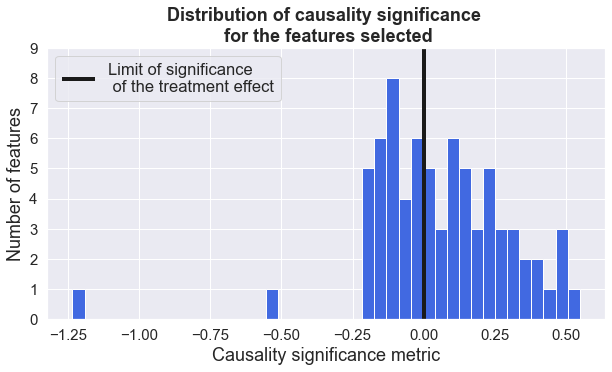

In [50]:
plt.figure(figsize=(10,5))
plt.hist(caus_metric, color='royalblue', bins=42)
plt.vlines(0,0,20, color='k', label="Limit of significance \n of the treatment effect", linewidth=4)
plt.title("Distribution of causality significance \n for the features selected", fontsize=18, fontweight='bold')
plt.xlabel('Causality significance metric', fontsize=18)
plt.ylabel('Number of features', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(0,9)

#plt.legend()
plt.legend(loc=2)
plt.show()

In [51]:
n_features_significant = np.sum(np.asarray(caus_metric) >= 0)
print("Number of features with a positive causality significance metric: {}".format(n_features_significant))

Number of features with a positive causality significance metric: 42


The features with a negative causality significance metric have a non significant effect on food purchase diversity. It is interesting because when computing the correlation between the features of the current dataset and the food purchase entropy, we isolated 74 features with a significant correlation. Now we observe that from these 73 features, only 42 actually have a causal effect on food purchase diversity. It means that 31 features have a significant correlation with the food purchase diversity, but when taking into account confounding factors we realize that the features have no causal effect on the food purchase diversity.

To better grasp the link between the correlations and the causality significance metrics computed and discussed previously, we will now plot each feature's results as a point on a correlation vs. causality significance metric graph.

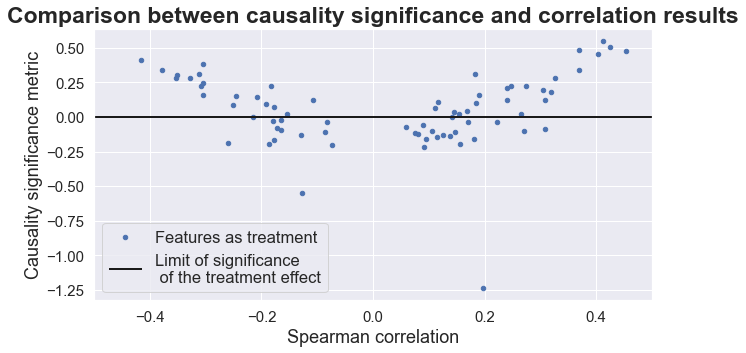

In [52]:
plt.figure(figsize=(10,5))

plt.scatter(corr_caus_df.correlation, corr_caus_df.caus_metric, s=20, label='Features as treatment')
plt.hlines(0, -0.7, 0.7, colors='k', linewidth=2, label='Limit of significance \n of the treatment effect');
#plt.hlines(-0.1, -0.5, 0.5, colors='m', Linestyle='--'); # safety factor ?
plt.xlabel('Spearman correlation', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.title("Comparison between causality significance and correlation results", fontsize=23, fontweight='bold')

plt.xlim(-0.5, 0.5)
plt.tick_params(labelsize=15)

plt.legend()
plt.show()

It must be noted that only the significant correlations are plotted here. The fact that many features that are correlated to the food purchase diversity are in fact not showing any causality link with this feature when considering confounding factors is really interesting. These are all the points below the black line at $y = 0$.

In addition, we can observe on the scatter that even though there is a trend showing that the more correlated (in absolute value), the more causal the relationship between the two variables is, this relation is not perfect. This is what we would have expected. Indeed, if the points were all located on the $y = A*|x|$ curve, with $A$ a constant, this would mean that the causality significance metric is simply another way of computing a correlation. This plot shows that features with a similar correlation can have different causality significance metrics. In some cases, two features with similar correlations lead to one feature having a causal link with food purchase entropy, and the other not, which showcases how useful GPS matching is in this analysis.

### 5.4. Anaylsis of the effect of each ethnicity on the product categories entropies

Now that we have clearly identified that the more diverse the population is (in terms of ethnicity), the more diverse the food purchase will be, let's get down to a finer level of granularity: Can the prevalence of a certain ethnic group cause a significative effect in purchased product diversity ? 

We have seen in the correlation analysis that the different ethnicities were correlated in specific manners to product categories entropy. However, as it was done for the study done with the food purchase and ethnicity diversity, we would like to determine whether those correlations lead to causal links between the different features.

To determine this, we process in a similar manner than previously, computing a GPS between a treatment and an outcome to remove the effect of confounding factors allowing to identify a causality link between the features.

In [53]:
ethnic_features = ['Ethnic_Group;White_(ratio);2011',
                   'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                   'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                   'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                   'Ethnic_Group;Other_ethnic_group_(ratio);2011']

ethnic_feat_short = ['White', 'Mixed', 'Asian', 'Black', 'Other']

h_features = ['h_items_food_norm', 'h_items_drink_norm']

food_features = ['f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 
                 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_sweets']

drink_features = ['f_beer', 'f_soft_drinks', 'f_spirits','f_tea_coffee', 'f_water', 'f_wine']

In [54]:
filtered_df.index = full_df.index
filtered_df = pd.concat([filtered_df, full_df.loc[:,h_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,food_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,drink_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,ethnic_features]], axis=1)

In [55]:
h_features.insert(0, 'h_items_norm')

res_h_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_h_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                        'Lower_CI', 'Upper_CI', 'outcome', 'treatment', 'is_causal'])

for outcome in h_features:
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df = compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_h_df = res_h_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                     'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
                
        is_causal = (treat_eff_metric > 0)
        gps_res['is_causal'] = np.repeat(is_causal, 100)
        caus_curve_h_df = caus_curve_h_df.append(gps_res, ignore_index=True)

In [56]:
caus_curve_h_df

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI,outcome,treatment,is_causal
0,-0.934,0.246,0.057,0.435,h_items_norm,White,True
1,-0.899,0.257,0.068,0.446,h_items_norm,White,True
2,-0.880,0.261,0.072,0.449,h_items_norm,White,True
3,-0.859,0.263,0.075,0.451,h_items_norm,White,True
4,-0.826,0.263,0.077,0.448,h_items_norm,White,True
...,...,...,...,...,...,...,...
1495,0.468,0.040,-0.094,0.174,h_items_drink_norm,Other,False
1496,0.468,0.040,-0.094,0.174,h_items_drink_norm,Other,False
1497,0.503,0.040,-0.097,0.177,h_items_drink_norm,Other,False
1498,0.539,0.040,-0.101,0.180,h_items_drink_norm,Other,False


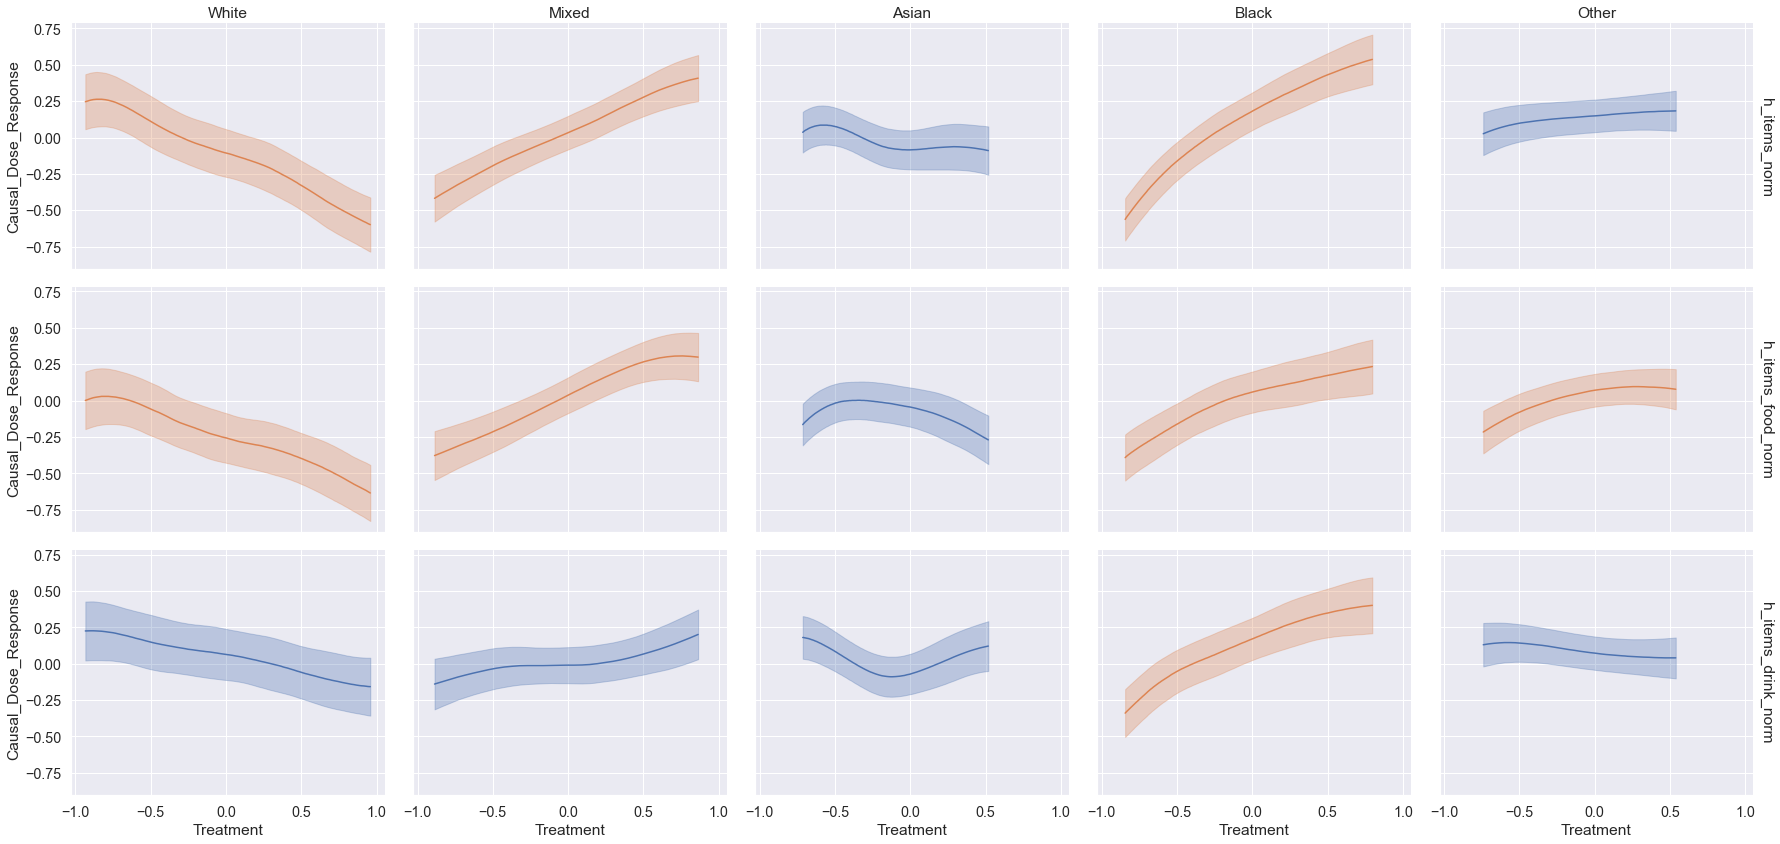

In [57]:
sns.set(font_scale=1.3)  # crazy big

p = sns.FacetGrid(caus_curve_h_df,
                  row='outcome',
                  col='treatment',
                  hue='is_causal',
                  height=4,
                  aspect=1.25,
                  margin_titles=True)
p.map(plt.fill_between, 'Treatment', 'Lower_CI', 'Upper_CI', alpha=.3)
p.map(plt.plot, 'Treatment', 'Causal_Dose_Response')
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

The figure above shows the CDR curve resulting from the GPS matching, for proportion of a certain ethnic group and product categories entropy. Significant and non significant causality relations are represented as orange and blue curves respectively.

We can see on this figure that not all of the ethnic groups have a significant impact on the product categories entropy (first row), even though all of them presented significant correlation values with it in section 4.2. We can indeed see that if the "White", "Mixed" and "Black" ethnic groups have a significant causal effect on the products diversity, "Asian" and "Other" are not significatively causal. 
We can observe that the overall tendency of the causal curves plotted here follows the same patterns as the correlations found previously: positive slopes for "Mixed" and "Black" reflect their positive correlations, and the negative slopes for "White" reflects its negative correlation.

Causal slopes related to food-only and drink-only products are also reported (2nd and 3rd rows). Here again we can observe that the food-products have a more significant effect from ethnicities than the drink-products in the same fashion as what we observed for the correlations.

These results suggest that the greater the prevalence of "White" ethnic group, the lower the shopping cart diversity, and inversely that the greater the prevalence of "Mixed" and "Black" ethnic groups, the higher the shopping cart diversity. 

To draw conclusions here, we are limited by the level of representativity of the Tesco dataset. Indeed, since the data cannot cover all the food consumption habit of the inhabitants of London, it is impossible to tell if the causality value between the proportion of a certain group and the diversity of product categories is due to an overall less diversified diet or simply less diversified purchases at Tesco itself. A causal curve with a negative slope could for example indicate that a specific group tends to get some particular products at Tesco and turn to other more specific sources (ethnic shops, farmers markets, bakeries, etc.) for the rest of their groceries.

### 5.5. Anaylsis of the effect of each ethnicity on each food/drink category 

Now that we have clearly identified that the more diverse the population is (in terms of ethnicity), the more diverse the food purchase will be, let's come back to another of our main questions of interest: Can we identify food categories that are an ethnicity purchases more specific to a certain ethnicity ? 

We have seen in the correlation analysis that the different ethnicities were correlated in specific manners to the different food categories. However, as it was done for the study done with the food purchase and ethnicity diversity, we would like to determine whether those correlations lead to causal links between the different features.

To determine this, we process in a similar manner than previously, computing a GPS between a treatment and an outcome to remove the effect of confounding factors allowing to identify a causality link between the features.

In [58]:
res_food_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_food_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                           'Lower_CI', 'Upper_CI', 'outcome', 'treatment', 'is_causal'])


causal_metric_distr = []
correl_distr = []

for outcome in food_features:
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_food_df = res_food_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                     'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
        
        R = ff_corr_df[np.logical_and(ff_corr_df['Item'] == outcome, ff_corr_df['Ethnicity'] == treat)]['R'].values
        p_val = ff_corr_df[np.logical_and(ff_corr_df['Item'] == outcome, ff_corr_df['Ethnicity'] == treat)]['p-value'].values
        if p_val < 0.05/85:
            correl_distr.append(R)
            causal_metric_distr.append(treat_eff_metric)
                
        is_causal = (treat_eff_metric > 0)
        gps_res['is_causal'] = np.repeat(is_causal, 100)
        caus_curve_food_df = caus_curve_food_df.append(gps_res, ignore_index=True)
        

In [59]:
caus_curve_food_df

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI,outcome,treatment,is_causal
0,-0.934,-0.084,-0.312,0.144,f_dairy,White,False
1,-0.899,-0.084,-0.312,0.144,f_dairy,White,False
2,-0.880,-0.085,-0.312,0.143,f_dairy,White,False
3,-0.859,-0.088,-0.314,0.139,f_dairy,White,False
4,-0.826,-0.095,-0.320,0.130,f_dairy,White,False
...,...,...,...,...,...,...,...
5495,0.468,-0.061,-0.179,0.057,f_sweets,Other,True
5496,0.468,-0.061,-0.179,0.057,f_sweets,Other,True
5497,0.503,-0.056,-0.177,0.065,f_sweets,Other,True
5498,0.539,-0.051,-0.175,0.073,f_sweets,Other,True


We will now plot the CDR curve resulting from the GPS matching, for every pair of ethnicity and food/drink category. As in the correlation analysis section, we will plot the results for food categories and drink categories in separate plots, for readability purposes. It will give an idea of what CDR curves can look like, as well as allowing us to interpret the results better. As all features used are standardized, all plots have the same axes scales, which simplifies comparisons of the results.

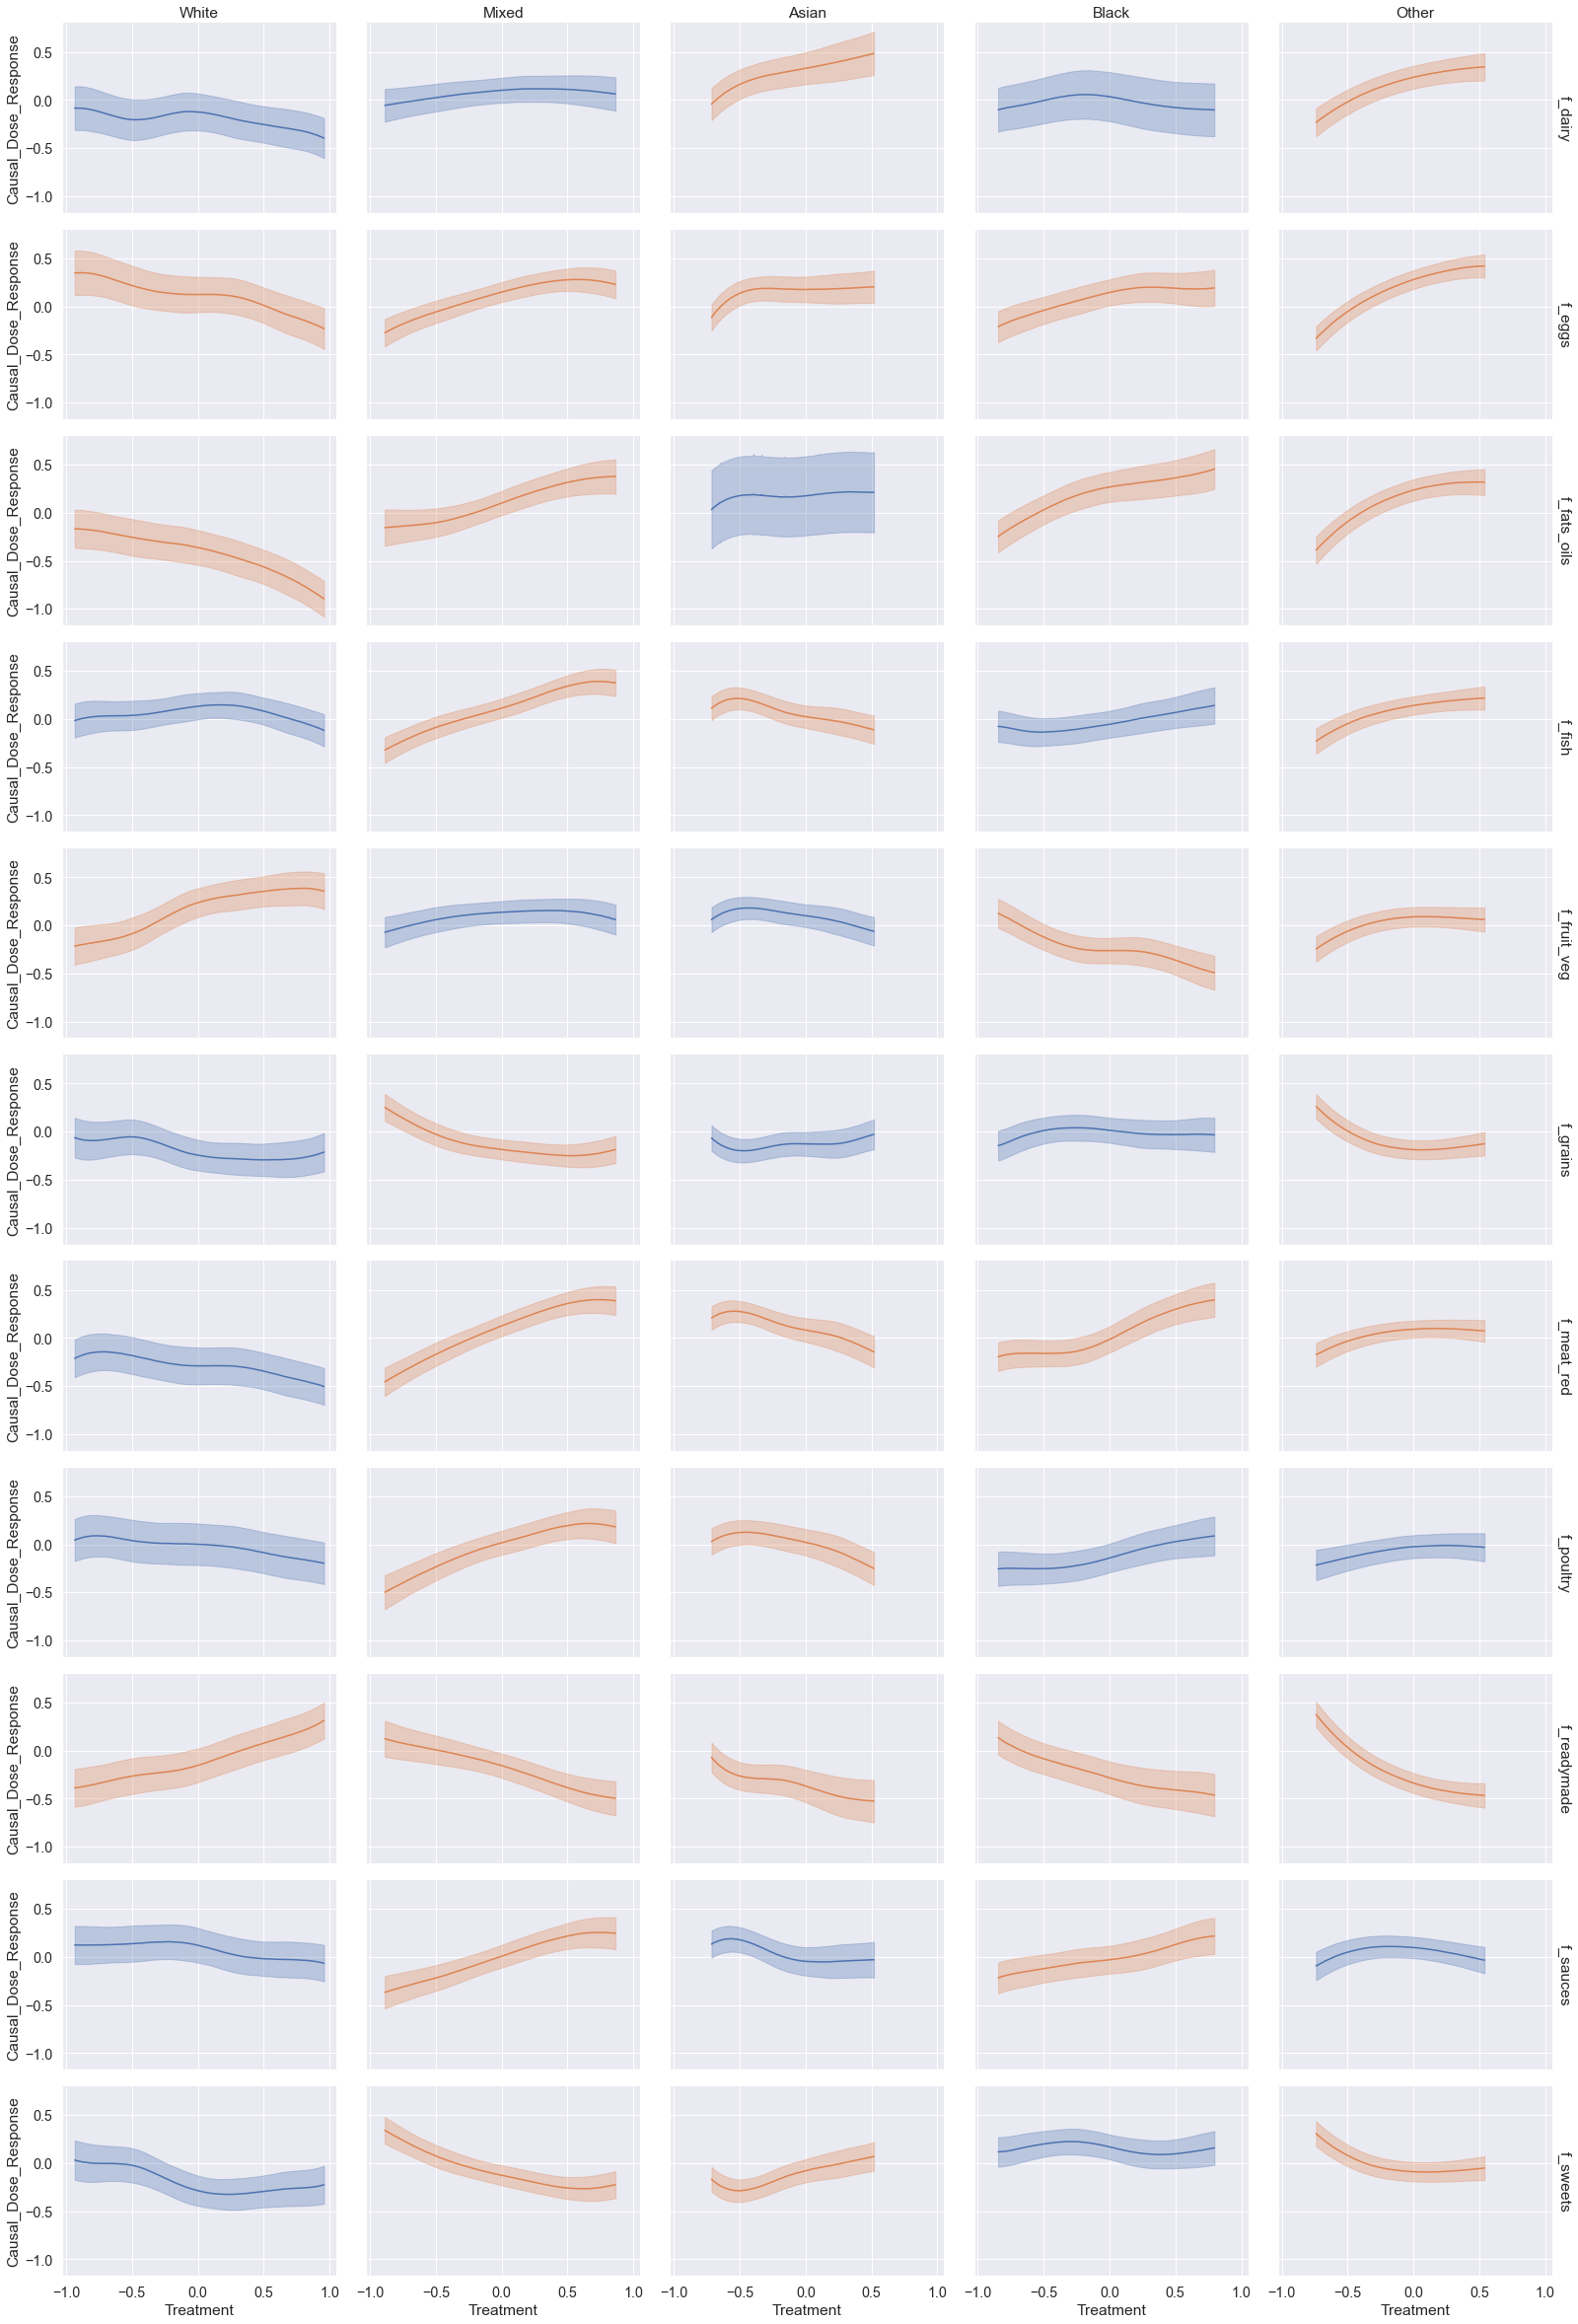

In [60]:
# with sns.plotting_context('paper', font_scale = 1.3):

sns.set(font_scale=1.3)  # crazy big

p = sns.FacetGrid(caus_curve_food_df,
                  row='outcome',
                  col='treatment',
                  hue='is_causal',
                  aspect=1.5,
                  margin_titles=True)
p.map(plt.fill_between, 'Treatment', 'Lower_CI', 'Upper_CI', alpha=.3)
p.map(plt.plot, 'Treatment', 'Causal_Dose_Response')
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

Each column represents an ethnicity (shown on top of the figure) and each row a food category (shown on the right of the figure). The curves are drawn in orange if the causal effect is significant and in blue otherwise. Let us comment on a few results:
- Most of the curves can be quite well approximated by a line with a constant slope. We cannot really find an example of a kind of parabolic curve where a horizontal line does not fit in the CI. Indeed, a few CDR curves in the case of the other ethnicity seem fully convex or concave, but there is no occurence where the maximum/minimum value of the CDR curve is in the middle of the treatment interval (around 0). This would be that low and high treatment values tend to decrease the expected proportion of food cateogry of interest, while a treatment value in-between increases it. As there are no such examples, we can visually comment the significant treatment effects (where no horizontal line can be contained in the CI) by labelling them as either having a positive or negative effect on the associated food category.
- The most significant effects of the white ethnicity are on the readymade and fats/oils categories. The first effect is positive while the second is negative. This means that an area with a higher proportion of people of white ethnicity there is an increased expected proportion of products bought in Tesco being readymade, and a decreased proportion belonging to the fats/oils category.
- The mixed ethnicity has a significant effect on most of the food categories proportions. Indeed, by visual inspection we observe that only its effect on fruit/vegetables and dairy categories is not significant.
- The asian ethnicity has a significant effect on many food categories, with their most significant effects being on the red meat and the dairy categories. These effects are respectively negative and positive.
- The most significant effects of the black ethnicity are on the readymade, fruits/vegetables, fats/oils and red meat categories. Its effect is negative for the former two categories while it is positive for the last two.
- The other ethnicity group has many very significant effects. For instance, it has negative effects on readymade and grains categories, and positive effects on fats/oils, eggs and dairy.
- All positive correlations computed in section 4.3 that yield a significant causal effect keep the same sign of the effect. Indeed, there is no example of a pair of features being negatively correlated and having a significant positive causal link.
- All ethnicities have a significant effect on the eggs and readymade categories

Let us now focus on three interesting pairs of features and their causal links:
- 1. Asian ethnicity and fat/oils category
- 2. White ethnicity and readymade category
- 3. Black ethnicity and fruits/vegetables category

The first pair has a correlation of 0.21, computed in section 4.3. However, as we see on the plot above, there does not seem to be any causal effect of the asian ethnicity proportion in a given LSOA on the proportion of fats and oils purchased. Furthermore, the CI is very large compared to the rest of the pairs tested. This relation is therefore correlated because of confounders found in the dataset.

The second pair has a correlation of 0.4. This strong correlation leads to a significant and approximatively linear causal effect in this case. Indeed, an increased proportion of people of white ethnicity in an LSOA will increase the expected proportion of readymade products purchased.

The third pair has a correlation of -0.25. It leads to a significant negative causal effect. 


Now that we have computed the causality significance metric for each pair of ethnicity and food category, we can plot relation between the correlation and causality of each pair of features. 

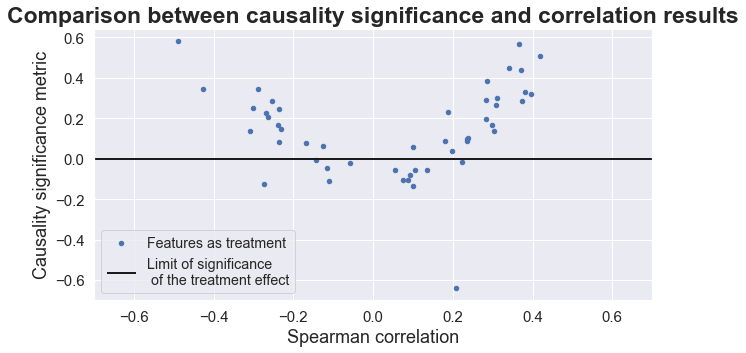

In [61]:
plt.figure(figsize=(10,5))

plt.scatter(correl_distr, causal_metric_distr, s=20, label='Features as treatment')
plt.hlines(0, -1, 1, colors='k', linewidth=2, label='Limit of significance \n of the treatment effect');
plt.xlabel('Spearman correlation', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.title("Comparison between causality significance and correlation results", fontsize=23, fontweight='bold')

plt.xlim(-0.7, 0.7)
plt.tick_params(labelsize=15)

plt.legend()
plt.show()

We observe that some pairs of features were correlated, but actually there is no causal effect of the ethnicity on the food category and these datapoints end up below $y = 0$. It is interesting to see that again, mulitple significant correlations end up being non significant causality relations. Indeed, only the significant correlations are plotted here. Out of the 55 pairs of combinations of features, 49 pairs have a significant correlations, but only 35 have a significant causal link from the ethnicity on the food category.

Let us now do the same thing with the drink categories.

In [62]:
res_drink_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_drink_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                            'Lower_CI', 'Upper_CI', 'outcome', 'treatment'])

causal_metric_distr = []
correl_distr = []

for outcome in drink_features:
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_drink_df = res_drink_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                            'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
        
        R = ff_corr_df[np.logical_and(ff_corr_df['Item'] == outcome, ff_corr_df['Ethnicity'] == treat)]['R'].values
        p_val = ff_corr_df[np.logical_and(ff_corr_df['Item'] == outcome, ff_corr_df['Ethnicity'] == treat)]['p-value'].values
        if p_val < 0.05/85:
            correl_distr.append(R)
            causal_metric_distr.append(treat_eff_metric)
 
        is_causal = (treat_eff_metric > 0)
        gps_res['is_causal'] = np.repeat(is_causal, 100)
        caus_curve_drink_df = caus_curve_drink_df.append(gps_res, ignore_index=True)
         

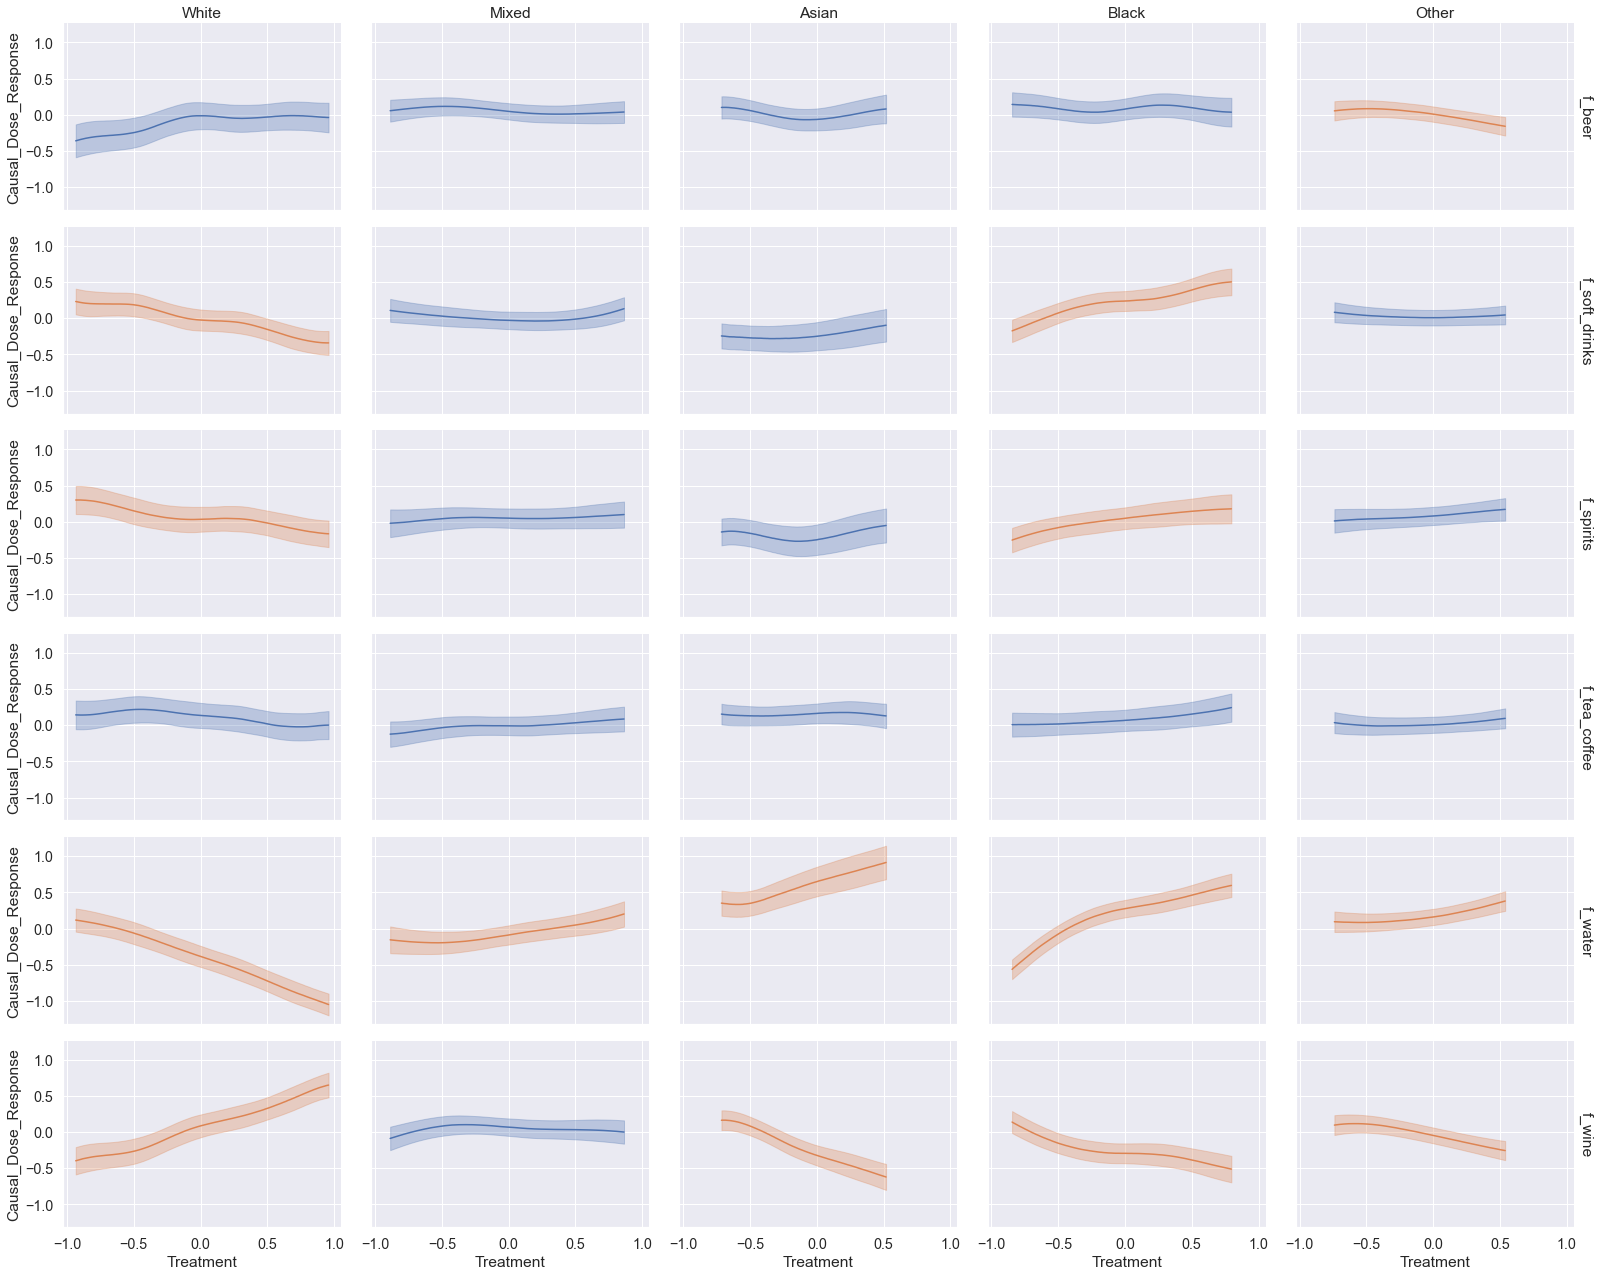

In [63]:
# with sns.plotting_context('paper', font_scale = 1.3):
p = sns.FacetGrid(caus_curve_drink_df,
                  row='outcome',
                  col='treatment',
                  hue='is_causal',
                  aspect=1.5,
                  margin_titles=True)
p.map(plt.fill_between, 'Treatment', 'Lower_CI', 'Upper_CI', alpha=.3)
p.map(plt.plot, 'Treatment', 'Causal_Dose_Response')
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

Each column represents an ethnicity (shown on top of the figure) and each row a drink category (shown on the right of the figure). Let us comment on a few results:
- In this case again, most of the curves can be quite well approximated by a line with a constant slope. Therefore we can visually comment the significant treatment effects by labelling them as either having a positive or negative effect on the associated food category.
- The most significant effects of the white ethnicity are on the water and wine categories. The first effect is negative while the second is positive. This means that an area with a higher proportion of people of white ethnicity there is an increased expected proportion of products bought in Tesco being readymade.
- The mixed ethnicity only has a significant effect the water category. This a big difference compared to the food categories where it has an effect on almost every category.
- The asian, black and other ethnicities all have there most significant effects on water and wine categories. It is worth noticing that these effects are in opposition to the ones of the white ethnicity.
- All positive correlations computed in section 4.3 that yield a significant causal effect keep the same sign of the effect. Indeed, there is no example of a pair of features being negatively correlated and having a significant positive causal link.
- All ethnicities have a significant causal effect on the water category.
- No ethnicity has a significant causal effect the tea/coffee and the beer categories. This is very interesting and it might suggest that people do not really purchase tea, coffee or beers in Tesco. As England is well known for beers and for tea, people might be willing to buy beers and tea in specialized stores. 

Now that we have computed the causality significance metric for each pair of ethnicity and drink category, we can plot relation between the correlation and causality of each pair of features. 

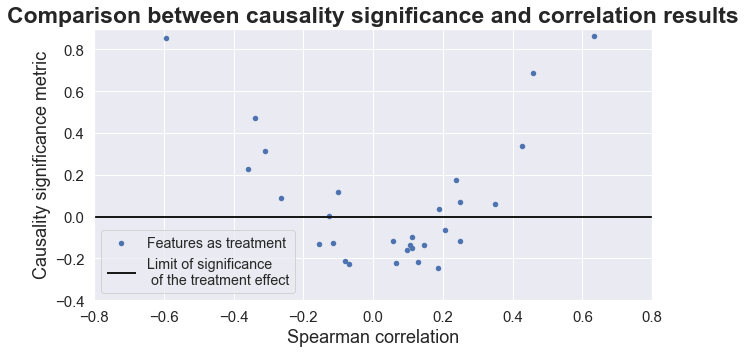

In [64]:
plt.figure(figsize=(10,5))

plt.scatter(correl_distr, causal_metric_distr, s=20, label='Features as treatment')
plt.hlines(0, -1, 1, colors='k', linewidth=2, label='Limit of significance \n of the treatment effect');
plt.xlabel('Spearman correlation', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.title("Comparison between causality significance and correlation results", fontsize=23, fontweight='bold')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.4, 0.9)
plt.tick_params(labelsize=15)

plt.legend(loc='best')
plt.show()

In this case, a lot of significant correlations are actually not causal in the end. Indeed, only the significant correlations are plotted here. Out of the 35 combinations of features studied, 34 are correlated, but only 13 have actually a causal link from the ethnicity on the drink category.

### 5.6. Interpretations of the results

We have observed many different interesting results in this project. From the correlations computed in section 4, it was difficult to draw conclusions on the effect of ethnicity on food purchase habits. The causality analysis gives us more confidence when interpreting the results. Even though many relations between ethnicities and food categories seem to have a causal link, we must always be careful with our interpretations. As stated before, data are aggregated, meaning that we cannot really draw conclusions about individuals, but rather about the proportion of specific individuals in an area. Furthermore, the food purchases only account for the people that shop at Tesco. We have no information about the purchases made at other supermarkets in London. Indeed, a lot of people do not ever shop at Tesco, while others do it once in a while, and others still only purchase specific products there.

An interesting example on which we will focus to show that conclusions are difficult to draw is the following: the effect of the proportion of people of asian ethnicity on the proportion of fish purchased in a given LSOA. This causal effect is significant and negative, meaning that an increased proportion of people of asian ethnicity in an LSOA decreases the proportion of fish purchased at Tesco. We were first really surprised by this result. Indeed, in Asia people typically tend to eat more fish than people in the UK. This is corroborated by results discussed here: https://today.uic.edu/researchers-to-measure-mercury-levels-in-asians#:~:text=Asians%20eat%20more%20fish%20than,on%20hair%20and%20blood%20analysis. 
It is stated than people of asian ethnicity "eat more fish than any other ethnic group in the United States". Another interesting discussion can be found here: https://www.tera.org/Publications/CDR%20Chapter5.pdf.
Why then is the causal effect not positive? How on Earth can it be negative? A potential hypothesis to explain this counterintuitive result is the following: maybe people of asian ethnicity shop less at Tesco compared to other ethnicities. Or maybe they purchase some products there, but they know a better store to buy fish of better quality. This is of course a wild guess, as we have no data to support it. However, it demonstrates well the fact that the results we found do not automatically relate to food habits, or even food purchase, as Tesco is obviously not the only option when it comes to buying food in London. 

Therefore, some of our results suggest causal effects of ethnicities distributions and diversity on food purchase diversity and food product categories shopped, but we can never be sure that these effects are due to differences in food habits, or differences in the way people purchase food.

Though, when focusing for example on the readymade category, we can maybe go a bit further in the conclusions that we draw. Indeed, all ethnicities have a significant negative causal effect on this food category, except for the white ethnicity which has a significant positive causal effect on it. In this case, we can interpret the results in the following way: people of white ethnicity typically purchase a lot more wine than people of the four other ethnicity groups. Therefore, when the proportion of people of white ethnicity in an area increases, the proportion of readymade products purchased in Tesco increases as well. As white ethnicity is the most represented ethnicity in London, by definition if the proportions of other ethnicities increase, in turn the expected proportion of people of white ethnicity in the area decreases, which in turn means that people who purchase a lot of readymade products are replaced by people who purchase less of these. So it makes sense that even if the other four ethnicities purchase some readymade food, as long as people of white ethnicity purchase more in average, then the causal effect of the other four ethnicities will tend to be negative.

## 6. Conclusion

After a correlation and a causality analysis on the effect of ethnicity on food purchase habits at Tesco in London, we can now answer the key questions presented at the start of this work:
- Does ethnic diversity have an effect on food purchase diversity at area level?
- And if yes, what is its nature? 
- To which extent is ethnic diversity responsible for food purchase diversity?  
- To which extent are ethnicities responsible for the changes in some product categories purchases? Can we attribute particular food purchase habits to specific ethnic groups?

As we observed a causal effect from the ethnicity diversity in a given area on the food purchase diversity in section 5.2.2. which was then validated by multiple tests in section 5.3., it suggests that the answer to the first question is yes. The results show that when the ethnicity diversity increases, the expected food purchase diversity in the same LSOA increases as well, which answers the second question. Indeed, it demonstrates that this causal effect is positive. 

In sections 5.2.3. we noted that the causality significance metric gives also information about the magnitude of the causal effect of the treatment on the output, when this effect is well approximated by a straight line. Results in section 5.4. highlighted that the vast majority of CDR curves can be approximated by a straight line. Coupled to the fact that the ethnic entropy has the 8th highest correlation with the food product category entropy and the 3rd highest causality significance metric among 73 features, it makes us confident that ethnic diversity is considerably responsible for food purchase diversity observed at Tesco in London LSOA. This answers the third question.

The last questions are more tricky. Indeed, we performed a thorough analysis on the effect of the ethncities proportions on the purchased food categories proportions. However, it is really difficult to attribute particular food purchase habits to specific ethnic groups. This is because we only have information about purchases at Tesco. Indeed, some people never shop there, others shop at Tesco every once in a while, while others shop only a fraction of their total food purchases at Tesco. Even though we found and described interesting results, we can only assume people habits, as we have no real way of validating our hypotheses.

Overall, this work provides a structured, step-by-step methodology to analyze the relation of two features of interest, starting by naive approaches before really putting their causal link to the test by using the notion of Generalized Propensity Score matching. The results were thoroughly analyzed to ensure that this algorithm gives relevant information about our dataset. In the end, we made some hypotheses on some of the tricky results that needed to be interpreted and we drew some conclusions from them.

## 7. Annex (visualizations for Data Story)

#### Correlation bar plot

In [ ]:
item_corr = np.concatenate((R_food_np, R_drink_np), axis=1)

ethnicities=['White', 'Mix. Eth.', 'Asian', 'Black', 'Oth. Eth. gr.']
food_it = ['Dairy', 'Eggs', 'Fats Oils', 'Fish', 'Fruit Veg.', 'Grains', 'Red Meat', 
           'Poultry', 'Ready made', 'Sauces', 'Sweets', 'Beer', 'Soft Drinks', 'Spirits',
           'Tea & Coffee', 'Water', 'Wine']

data = []

for i, eth in enumerate(ethnicities):
    colors = ['darkcyan' if val > 0 else 'crimson' for val in item_corr[i,:]]
    data.append(go.Bar(x=food_it, y=item_corr[i,:], name=eth, marker_color=colors,
                       visible=False))               

data[0]['visible'] = True

In [ ]:
layout = go.Layout(yaxis_title="Spearman Rank Correlation",
                   xaxis_title="Tesco items",
                   title={'text': "Correlation between Ethnicity and Tesco items",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
                  )

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False]],
                    label='White',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False]],
                    label='Mix. Eth.',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False]],
                    label='Asian',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False]],
                    label='Black',
                    method='restyle'
                )
                ,
                dict(
                    args=['visible', [False, False, False, False, True]],
                    label='Other Eth. gr.',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
fig = fig.add_shape(type="line",
                    x0=10.5, y0=-0.7, x1=10.5, y1=0.7,
                    line=dict(color="lightslategrey",width=1)
                    )
fig = fig.add_shape(type="line",
                    x0=-0.5, y0=-0, x1=16.5, y1=0,
                    line=dict(color="lightslategrey",width=1.5)
                    )

fig.show()

In [ ]:
item_corr = np.concatenate((R_food_np, R_drink_np), axis=1).T

data = []

for i, food in enumerate(food_it):
    colors = ['darkcyan' if val > 0 else 'crimson' for val in item_corr[i,:]]
    data.append(go.Bar(x=ethnicities, y=item_corr[i,:], name=food, marker_color=colors,
                       visible=False))               

data[0]['visible'] = True

In [ ]:
layout = go.Layout(yaxis_title="Spearman Rank Correlation",
                   xaxis_title="Ethnicities",
                   title={'text': "Correlation between Ethnicity and Tesco items",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
                  )

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(args=['visible', [True, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Dairy',method='restyle'),
                dict(args=['visible', [False, True, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Eggs',method='restyle'),
                dict(args=['visible', [False, False, True, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fats Oils', method='restyle'),
                dict(args=['visible', [False, False, False, True, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fish',method='restyle'),
                dict(args=['visible', [False, False, False, False, True, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fruit Veg.', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, True, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Grains',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, True, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Red Meat', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, True, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Poultry',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, True, 
                                       False, False, False, False, False, False, False, False]],
                    label='Ready made', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       True, False, False, False, False, False, False, False]],
                    label='Sauces',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, True, False, False, False, False, False, False]],
                    label='Sweets', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, True, False, False, False, False, False]],
                    label='Beer',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, True, False, False, False, False]],
                    label='Soft Drinks', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, True, False, False, False]],
                    label='Spirits',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, True, False, False]],
                    label='Tea & Coffee', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, True, False]],
                    label='Water',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, True]],
                    label='Wine', method='restyle')
            ])
        )]))
fig=go.Figure(data=data, layout =layout)
fig = fig.add_shape(type="line",
                    x0=0.5, y0=-0.7, x1=0.5, y1=0.7,
                    line=dict(color="lightslategrey",width=0)
                    )
fig.show()

#### Map plots

In [ ]:
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

In [ ]:
import json

In [ ]:
df = full_df

geojson_string = gpd.GeoSeries([df['geometry'][0]]).to_json()
# using json.loads() 
# convert dictionary string to dictionary 
res = json.loads(geojson_string)
res['features'][0]['id'] = df.index[0]

json_dict = res

for i in range(1, df.shape[0]):
    tmp_json_string = gpd.GeoSeries([df['geometry'][i]]).to_json()
    res = json.loads(tmp_json_string)
    res['features'][0]['id'] = df.index[i]
    geo_json = res['features'][0]
    append_value(json_dict, 'features', geo_json)

In [ ]:
features = ['f_fruit_veg', 'f_dairy', 'f_grains', 'f_meat_red', 'f_poultry', 'f_eggs', 'f_fats_oils', 'f_fish',
            'f_readymade', 'f_sauces', 'f_sweets']
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False, False, False, False, False, False]],
                    label='Fruit Vegetables',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False, False, False, False, False, False]],
                    label='Dairy',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False, False, False, False, False, False]],
                    label='Grains',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False, False, False, False, False, False]],
                    label='Red Meat',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False, False, False, False, False, False]],
                    label='Poultry',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True, False, False, False, False, False]],
                    label='Eggs',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, True, False, False, False, False]],
                    label='Fats Oil',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, True, False, False, False]],
                    label='Fish',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, True, False, False]],
                    label='Ready Made',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, True, False]],
                    label='Sauces',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, False, True]],
                    label='Sweets',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

In [ ]:
features = ['f_wine', 'f_soft_drinks', 'f_spirits', 'f_tea_coffee', 'f_water', 'f_beer']
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False]],
                    label='Wine',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False]],
                    label='Soft Drinks',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False]],
                    label='Spirits',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False]],
                    label='Tea & Coffee',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False]],
                    label='Water',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True]],
                    label='Beer',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

In [ ]:
feats = ['Ethnic_Group;White_(ratio);2011',
         'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
         'Ethnic_Group;Asian/Asian_British_(ratio);2011',
         'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
         'Ethnic_Group;Other_ethnic_group_(ratio);2011']

eth_df = df[feats]
eth_df.columns = ['White(%)', 'Mixed Eth.(%)', 'Asian(%)', 'Black(%)', 'Oth. Eth. Gr.(%)']

features = eth_df.columns
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = eth_df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False]],
                    label='White',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False]],
                    label='Mixed Eth.',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False]],
                    label='Asian',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False]],
                    label='Black',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True]],
                    label='Other Eth. Gr.',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

#### Paircat plot

In [ ]:
employ = full_df['Economic_Activity;Employment_ratio;2011']
salary = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
items_entropy = full_df['h_items_norm']
avg_age = full_df['avg_age']
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']

In [ ]:
# Create dimensions
rich_cat_feat = pd.cut(salary, bins=np.quantile(salary, [0, 0.1, 0.25, 0.75, 0.9, 1]), labels=[0,1,2,3,4],
                       include_lowest=True)

rich_dim = go.parcats.Dimension(values=rich_cat_feat, label="Richness of the area",
                                categoryarray=[0, 1, 2, 3, 4], 
                                ticktext=["very poor", "poor", "medium", "rich", "very rich"])

employ_cat_feat = pd.cut(employ, bins=[0, 50, 60, 70, 80, 100], labels=[0,1,2,3,4],
                         include_lowest=True)

employ_dim = go.parcats.Dimension(values=employ_cat_feat, label="Employment rate",
                                  categoryarray=[0, 1, 2, 3, 4], 
                                  ticktext=['0 to 50%', '50 to 60%', '60 to 70%', '70 to 80%', '80 to 100%'])

age_cat_feat = pd.cut(avg_age, bins=[25, 30, 35, 40, 45, 60], labels=[0,1,2,3,4],
                      include_lowest=True)

age_dim = go.parcats.Dimension(values=age_cat_feat, label="Avg. Age of the area",
                               categoryarray=[0, 1, 2, 3, 4], 
                               ticktext=['25 to 30', '30 to 35', '35 to 40', '40 to 45', '45 to 60'])

hitems_cat_feat = pd.cut(items_entropy, bins=np.quantile(items_entropy, [0, 0.1, 0.25, 0.75, 0.9, 1]),
                         labels=["very similar", "similar", 'medium', "diverse", "very diverse"], 
                         include_lowest=True)

hitems_dim = go.parcats.Dimension(values=hitems_cat_feat, label="Food Purchase Diversity of the area")

h_ethnicity_cat_feat = pd.cut(h_ethnicity, bins=np.quantile(h_ethnicity, [0, 0.1, 0.25, 0.75, 0.9, 1]),
                                  labels=["very similar", "similar", "medium", "diverse", "very diverse"],
                                  include_lowest=True)

h_ethnicity_dim = go.parcats.Dimension(values=h_ethnicity_cat_feat, label="Ethnicity Diversity of the area")


# Create parcats trace
#color = df_cat.Ethnicity_entropy;
color = rich_cat_feat;
color2 = employ_cat_feat;
color3 = age_cat_feat;
colorscale = px.colors.sequential.Inferno;
#[[0, 'aliceblue'], [1, 'limegreen']];

data = [go.Parcats(dimensions=[hitems_dim, rich_dim, h_ethnicity_dim],
                                   line={'color': color, 'colorscale': colorscale},
                                   hoveron='color', hoverinfo='count+probability',
                                   labelfont={'size': 14, 'family': 'Times'},
                                   tickfont={'size': 12, 'family': 'Times'},
                                   arrangement='freeform', visible=True),
        go.Parcats(dimensions=[hitems_dim, employ_dim, h_ethnicity_dim],
                   line={'color': color2, 'colorscale': colorscale},
                   hoveron='color', hoverinfo='count+probability',
                   labelfont={'size': 14, 'family': 'Times'},
                   tickfont={'size': 12, 'family': 'Times'},
                   arrangement='freeform', visible=False),
        go.Parcats(dimensions=[hitems_dim, age_dim, h_ethnicity_dim],
                   line={'color': color3, 'colorscale': colorscale},
                   hoveron='color', hoverinfo='count+probability',
                   labelfont={'size': 14, 'family': 'Times'},
                   tickfont={'size': 12, 'family': 'Times'},
                   arrangement='freeform', visible=False)
       ]

layout = go.Layout()

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False]],
                    label='Richness',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False]],
                    label='Employment Rate',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True]],
                    label='Avg. Age',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)

fig.show()

#### Linear regression plot

In [ ]:
pred_list = []
r2_list = []

#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['h_ethnicity'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['employment_rate'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['avg_age'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['median_household_income'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'avg_age']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'median_household_income']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'avg_age', 
                                                                'median_household_income', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['avg_age','median_household_income', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)

In [ ]:
from plotly.offline import init_notebook_mode, iplot, plot
from plotly import tools
from plotly.subplots import make_subplots

In [ ]:
### Create individual figures
# START
fig = tools.make_subplots(rows=1, cols=2, column_widths=[0.7, 0.3], 
                          subplot_titles=('Regression prediction',  'Variance Explained'))

trace1 = go.Scatter(x = y_test, y = pred_list[0], mode = 'markers', showlegend=False, visible=True, marker=dict(size=3))
trace2 = go.Scatter(x = y_test, y = pred_list[1], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace3 = go.Scatter(x = y_test, y = pred_list[2], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace4 = go.Scatter(x = y_test, y = pred_list[3], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace5 = go.Scatter(x = y_test, y = pred_list[4], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace6 = go.Scatter(x = y_test, y = pred_list[5], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace7 = go.Scatter(x = y_test, y = pred_list[6], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace8 = go.Scatter(x = y_test, y = pred_list[7], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace9 = go.Scatter(x = y_test, y = pred_list[8], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))

fig.append_trace(trace1, 1, 1)
fig.update_layout(yaxis_range=[-6,3], xaxis_range=[-6,3])
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)
fig.append_trace(trace5, 1, 1)
fig.append_trace(trace6, 1, 1)
fig.append_trace(trace7, 1, 1)
fig.append_trace(trace8, 1, 1)
fig.append_trace(trace9, 1, 1)

trace11 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[0]],
                width=0.2, showlegend=False, visible=True)
trace12 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[1]],
                width=0.2, showlegend=False, visible=False)
trace13 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[2]],
                width=0.2, showlegend=False, visible=False)
trace14 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[3]],
                width=0.2, showlegend=False, visible=False)
trace15 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[4]],
                width=0.2, showlegend=False, visible=False)
trace16 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[5]],
                width=0.2, showlegend=False, visible=False)
trace17 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[6]],
                width=0.2, showlegend=False, visible=False)
trace18 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[7]],
                width=0.2, showlegend=False, visible=False)
trace19 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[8]],
                width=0.2, showlegend=False, visible=False)

fig.append_trace(trace11, 1, 2)
fig.append_trace(trace12, 1, 2)
fig.append_trace(trace13, 1, 2)
fig.append_trace(trace14, 1, 2)
fig.append_trace(trace15, 1, 2)
fig.append_trace(trace16, 1, 2)
fig.append_trace(trace17, 1, 2)
fig.append_trace(trace18, 1, 2)
fig.append_trace(trace19, 1, 2)
# END

### Create buttons for drop down menu
labels=['Div. Eth.', 'Employ. Rate', 'Avg. Age', 'Med. Income', 'Eth. + Employ.', 'Eth. + Age', 'Eth. + Income',
        'Eth. + Employ. + Age + Inc.', 'Employ. + Age + Inc.']
buttons = []
for i, label in enumerate(labels):
    visibility = [i==j for j in range(len(labels))]
    button = dict(
                 label =  label,
                 method = 'update',
                 args = [{'visible': visibility},
                     #{'title': label}
                        ])
    buttons.append(button)

updatemenus = list([
    dict(active=0,
         x=0.1,
         y=1.2,
         buttons=buttons
    )
])

fig['layout']['title'] = {'text': "Regression Analysis",
                          'y':0.95,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
fig['layout']['showlegend'] = True
fig['layout']['updatemenus'] = updatemenus
# edit axis labels
fig['layout']['xaxis']['title']='True items diversity'
fig['layout']['yaxis']['title']='Predicted items diversity'
#fig['layout']['yaxis2']['title']='Variance Explained'
fig['layout']['yaxis2']['range']=[0,0.2]

iplot(fig, filename='dropdown')

In [ ]:
col_causal = ['aliceblue' if met < 0 else 'lightpink' for met in caus_metric]

fig = go.Figure(data=[go.Table(
    columnwidth = [400,80,80],
    header=dict(values=list(sort_df.columns[0:5]),
                #fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[sort_df.feature, sort_df.correlation, 
                       sort_df.caus_metric, sort_df.corr_rank, sort_df.caus_rank],
               line_color=[col_causal], fill_color=[col_causal],
               #fill_color='lavender',
               align='left'))
])

fig.show()